In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

In [2]:
sns.set_context("talk", font_scale=1.0)

In [2]:
# Directory containing the JSON files
directory_path = 'validate/'

# List to store the processed data
all_experiments = []

# Iterate through all JSON files in the directory
for file_path in glob.glob(os.path.join(directory_path, '**/*.json'), recursive=True):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract the model name from the file path
    model_name = os.path.basename(os.path.dirname(file_path)).split("_")[0]
    dataset_name = os.path.basename(file_path).split("_")[1].split(".")[0]
    
    for experiment in data['experiments']:
        # Flatten the dictionary to include metrics at the top level
        experiment_flat = {**experiment, **experiment.pop('metrics')}
        # Add the model name and dataset name to the experiment data
        experiment_flat['model'] = model_name
        experiment_flat['dataset'] = dataset_name
        # Append the processed experiment to the list
        all_experiments.append(experiment_flat)

# Create a DataFrame from the combined data
df = pd.DataFrame(all_experiments)
df.drop("metrics", axis="columns", inplace=True)

# Replace epsilons for early experiments where epsilon was rounded before saving
epsilon_replacements = {
    0.0000: 0.0039,
    0.0100: 0.0078,
    0.0200: 0.0157,
    0.0300: 0.0314
}
df['epsilon'] = df['epsilon'].replace(epsilon_replacements)

# Set iterations and epsilon to 0 where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'iterations'] = 0
df.loc[df['attack'] == 'none', 'epsilon'] = 0
# Replace 'epe_orig_preds' with 'epe' where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'epe_orig_preds'] = df['epe']
# Replace 'epe_ground_truth' with 'epe' where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'epe_ground_truth'] = df['epe']

# Get unique attack types excluding 'none'
attack_types = df['attack'].unique()
attack_types = attack_types[attack_types != 'none']

# Filter entries with attack == 'none'
none_entries = df[df['attack'] == 'none']

# Create copies of 'none' entries for each attack type
new_entries = []
for attack in attack_types:
    temp = none_entries.copy()
    temp['attack'] = attack
    new_entries.append(temp)

# Combine all new entries into a single DataFrame
new_entries_df = pd.concat(new_entries)

# Combine the new entries with the original DataFrame
result_df = pd.concat([df, new_entries_df])


# Keep only most recent results
# Convert 'start_time' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])

# Sort the DataFrame by 'start_time'
df = df.sort_values(by='start_time')

# Drop duplicates, keeping the most recent entry for each combination of specified columns
unique_columns = ['model', 'checkpoint', 'attack', 'targeted', 'target', 'dataset', 'norm', 'epsilon', 'iterations', 'alpha']
df = df.drop_duplicates(subset=unique_columns, keep='last')
df

start_time        model checkpoint  attack  targeted  \
348  2024-05-14 22:22:34       rpknet      kitti     bim      True   
349  2024-05-14 22:31:41       rpknet      kitti     bim      True   
351  2024-05-14 22:47:53       rpknet      kitti     pgd      True   
352  2024-05-14 23:10:29       rpknet      kitti     pgd      True   
354  2024-05-14 23:24:18       rpknet      kitti  cospgd      True   
...                  ...          ...        ...     ...       ...   
636  2024-06-24 20:15:49     starflow      kitti    none     False   
185  2024-06-24 20:17:40       csflow      kitti    none     False   
1555 2024-06-24 20:29:54  maskflownet      kitti    none     False   
567  2024-06-24 20:31:31       flow1d      kitti    none     False   
964  2024-06-24 20:33:06   flowformer      kitti    none     False   

                 end_time  duration     dataset        epe       px1  ...  \
348   2024-05-14 22:28:59  00:06:25  kitti-2015  72.925071  0.102532  ...   
349   2024-05-14 22:37:11  00:05:29  kitti-2015  36.213844  0.117752  ...   
351   2024-05-14 22:53:26  00:05:32  kitti-2015  73.048842  0.102415  ...   
352   2024-05-14 23:15:14  00:04:45  kitti-2015  36.299436  0.117158  ...   
354   2024-05-14 23:29:10  00:04:52  kitti-2015  73.038204  0.102184  ...   
...                   ...       ...         ...        ...       ...  ...   
636   2024-06-24 20:17:38  00:01:49  kitti-2015   2.924743  0.662907  ...   
185   2024-06-24 20:19:38  00:01:57  kitti-2015   0.710813  0.861653  ...   
1555  2024-06-24 20:31:24  00:01:30  kitti-2015   1.624903  0.738336  ...   
567   2024-06-24 20:32:56  00:01:25  kitti-2015   0.655199  0.869531  ...   
964   2024-06-24 20:43:48  00:10:42  kitti-2015   0.485420  0.902453  ...   

      own_epe_orig_preds  cosim_target  cosim_orig_preds  epe_ground_truth  \
348                  NaN     -0.958597          0.958597          1.279766   
349                  NaN      0.000000          0.960986          1.276016   
351                  NaN     -0.956979          0.956979          1.210561   
352                  NaN      0.000000          0.959176          1.194020   
354                  NaN     -0.963203          0.963203          1.205238   
...                  ...           ...               ...               ...   
636                  NaN           NaN               NaN          2.924743   
185                  NaN           NaN               NaN          0.710813   
1555                 NaN           NaN               NaN          1.624903   
567                  NaN           NaN               NaN          0.655199   
964                  NaN           NaN               NaN          0.485420   

      own_epe_ground_truth cosim_ground_truth  iterations alpha boxconstraint  \
348                    NaN           0.182229         3.0  0.01           NaN   
349                    NaN           0.182289         3.0  0.01           NaN   
351                    NaN           0.182333         3.0  0.01           NaN   
352                    NaN           0.182372         3.0  0.01           NaN   
354                    NaN           0.182374         3.0  0.01           NaN   
...                    ...                ...         ...   ...           ...   
636                    NaN                NaN         0.0   NaN           NaN   
185                    NaN                NaN         0.0   NaN           NaN   
1555                   NaN                NaN         0.0   NaN           NaN   
567                    NaN                NaN         0.0   NaN           NaN   
964                    NaN                NaN         0.0   NaN           NaN   

      conf_f1  
348       NaN  
349       NaN  
351       NaN  
352       NaN  
354       NaN  
...       ...  
636       NaN  
185       NaN  
1555      NaN  
567       NaN  
964       NaN  

[1910 rows x 30 columns]

In [19]:
df["epsilon"].value_counts()

epsilon
0.0078    429
0.0039    392
0.0157    391
0.0314    386
0.0050    290
0.0000     22
Name: count, dtype: int64

#### FGSM ALL + MAIN Models L-infinity Norm

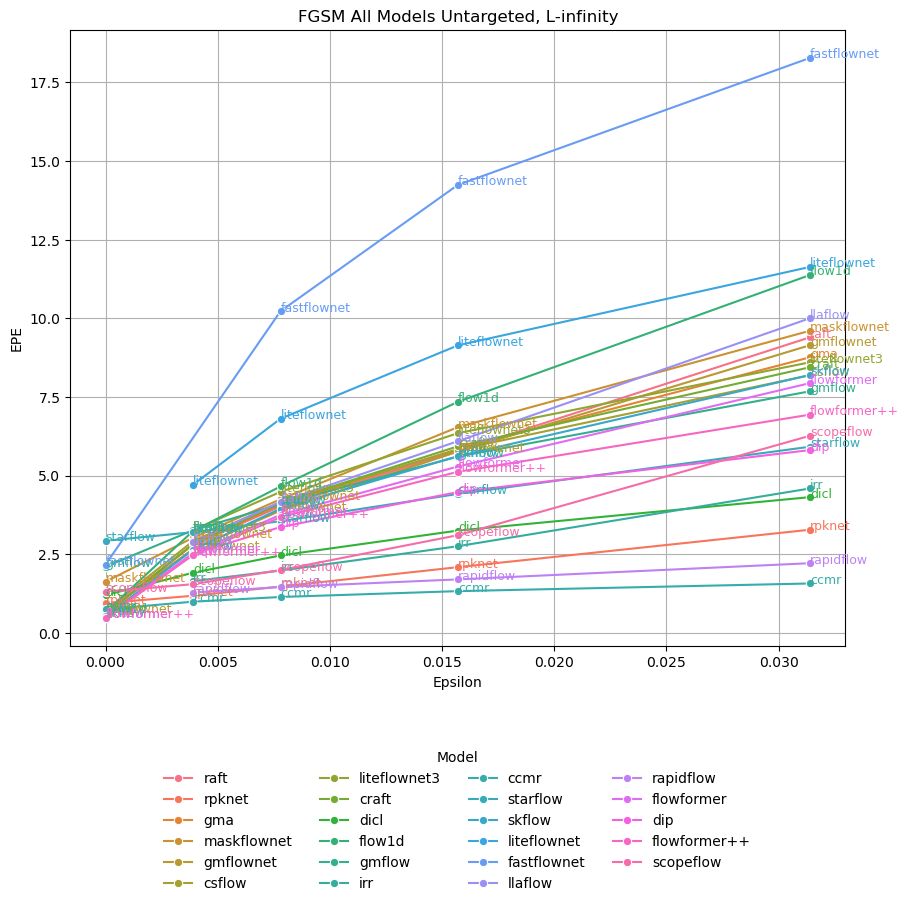

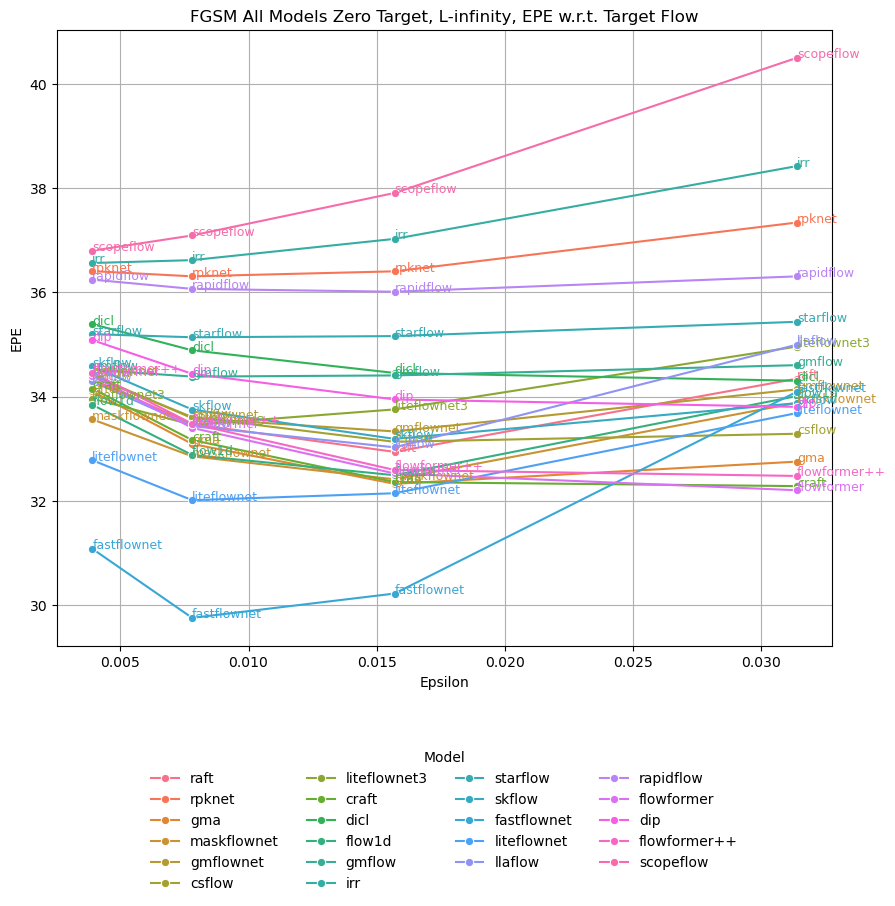

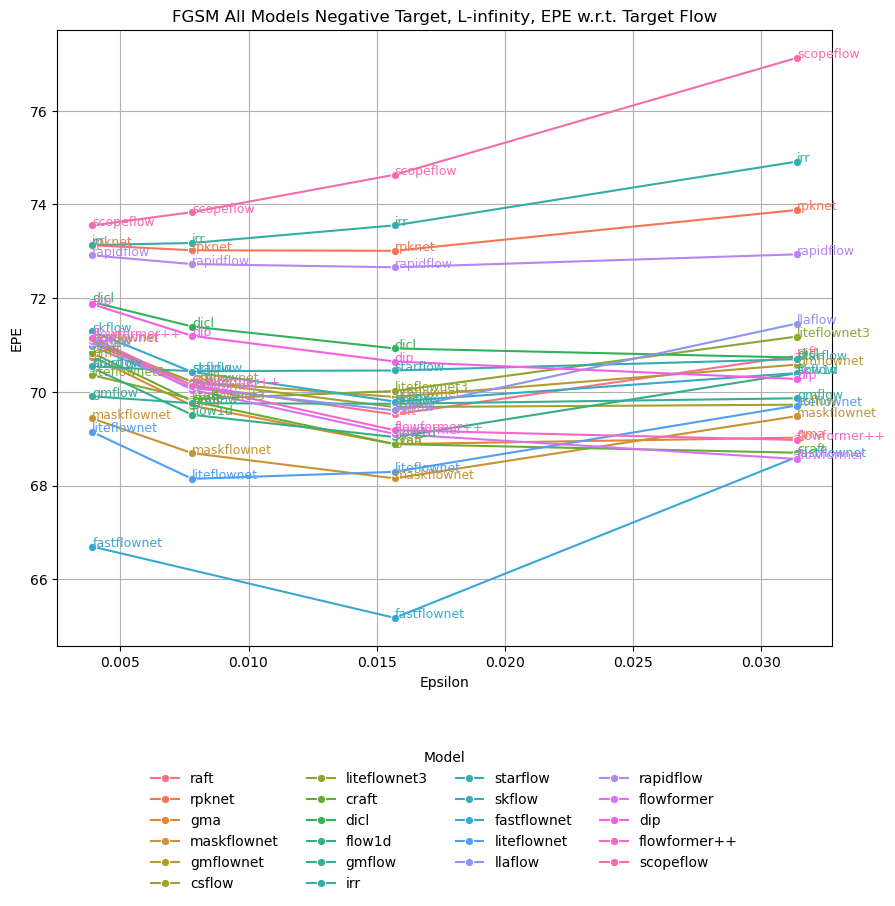

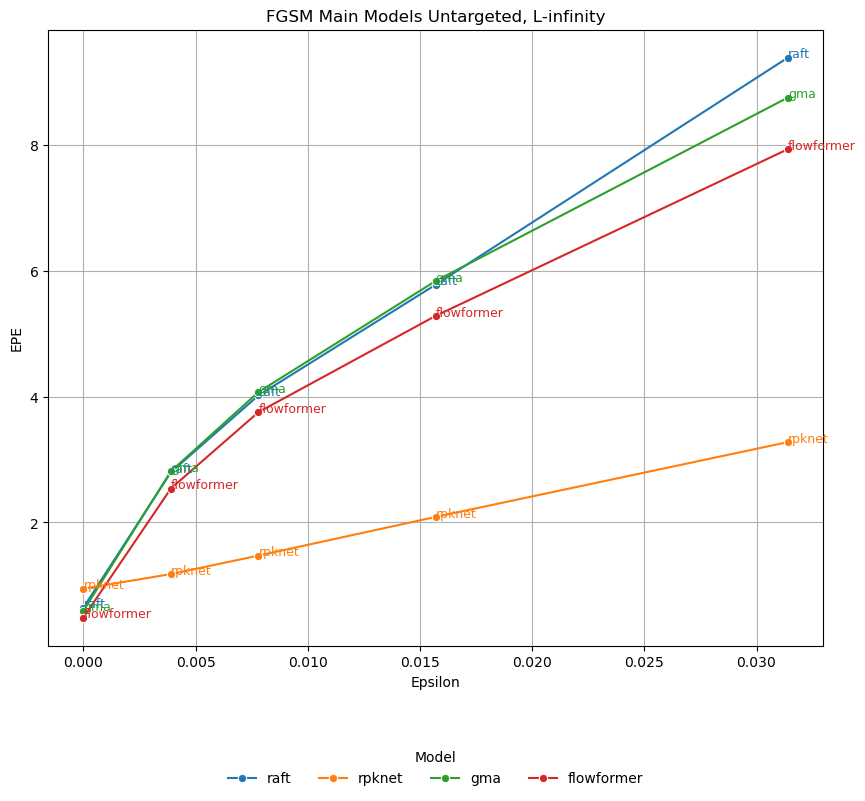

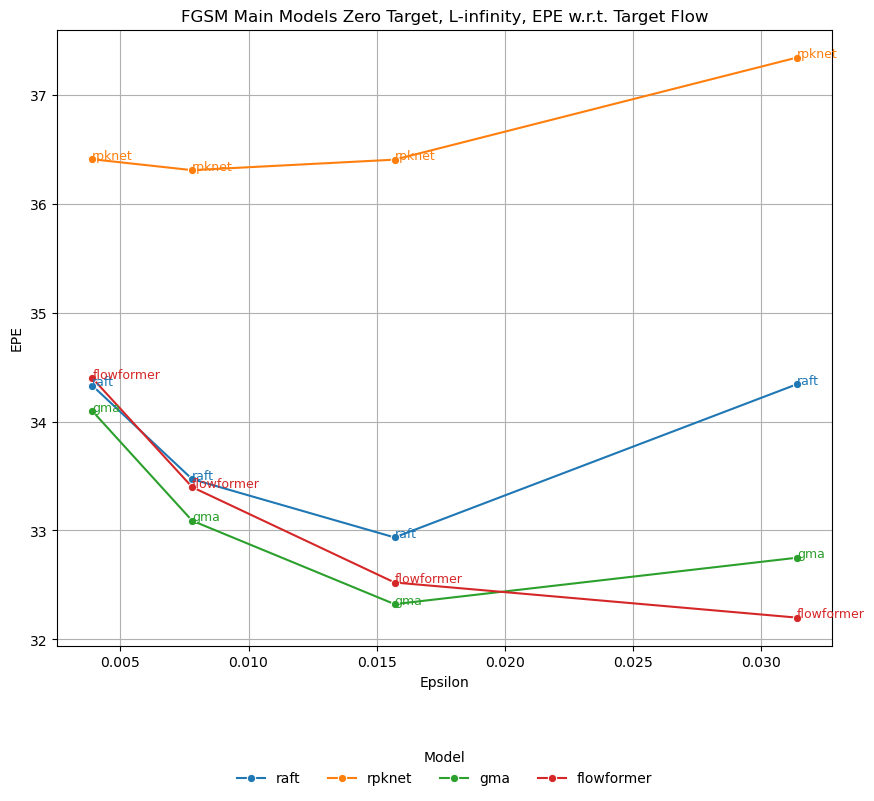

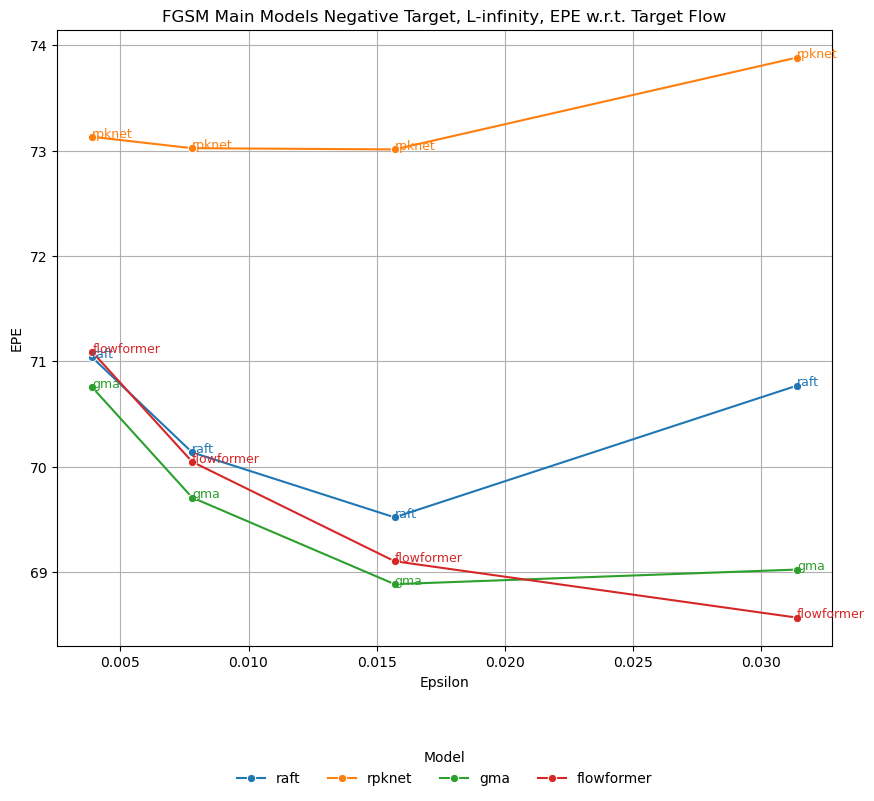

In [3]:
def plot_line(data, title, filename):
    # Create the plot
    plt.figure(figsize=(10, 8))
    line_plot = sns.lineplot(data=data, x='epsilon', y='epe', hue='model', marker='o')

    # Customize the plot
    plt.xlabel('Epsilon')
    plt.ylabel('EPE')
    plt.grid(True)
    plt.title(title)

    # Add annotations
    # Get colors from the legend
    handles, labels = line_plot.get_legend_handles_labels()
    legend_colors = dict(zip(labels, [handle.get_color() for handle in handles]))

    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        for i in range(model_data.shape[0]):
            plt.text(model_data['epsilon'].iloc[i], model_data['epe'].iloc[i], model, fontsize=9, color=legend_colors[model])

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti' or (attack == 'none' and checkpoint == 'kitti')")
plot_line(data_untargeted, "FGSM All Models Untargeted, L-infinity", 'graphs/FGSM All Models Untargeted INF.png')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_line(data_target_zero, "FGSM All Models Zero Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM All Models Zero Target INF.png')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_line(data_target_negative, "FGSM All Models Negative Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM All Models Negative Target INF.png')

specific_models = ['raft', 'pwcnet', 'gma', 'flownet2', 'flowformer', 'rpknet']

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_line(data_specific_models_untargeted, "FGSM Main Models Untargeted, L-infinity", 'graphs/FGSM Main Models Untargeted INF.png')

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_line(data_specific_models_target_zero, "FGSM Main Models Zero Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM Main Models Zero Target INF.png')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_line(data_specific_models_target_negative, "FGSM Main Models Negative Target, L-infinity, EPE w.r.t. Target Flow", 'graphs/FGSM Main Models Negative Target INF.png')


#### FGSM ALL + MAIN Models L-infinity Norm - Targeted w.r.t. Ground Truth

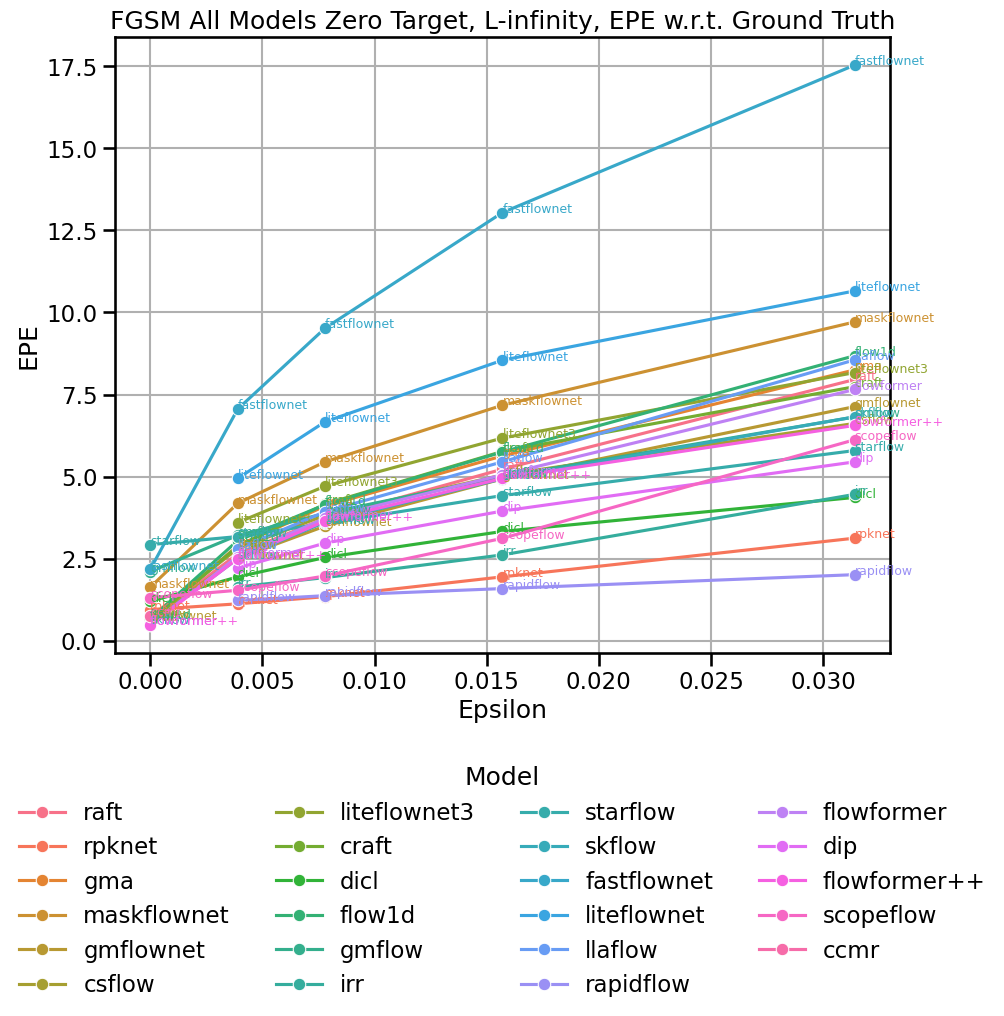

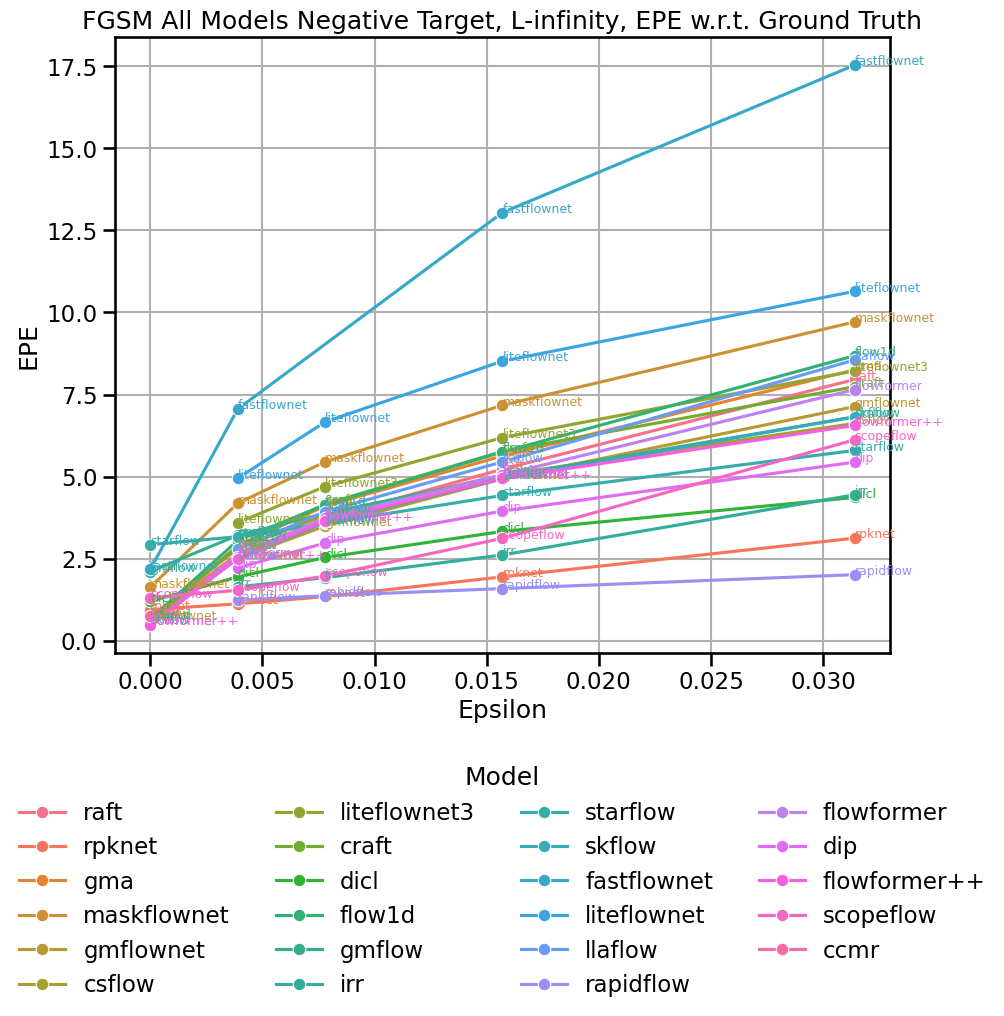

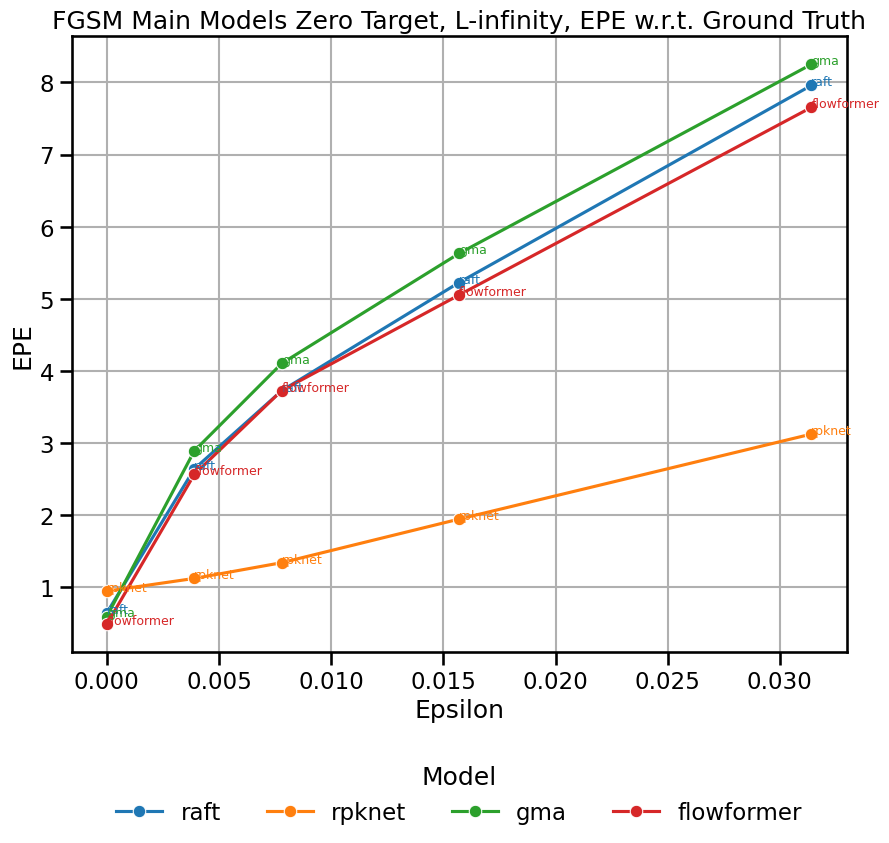

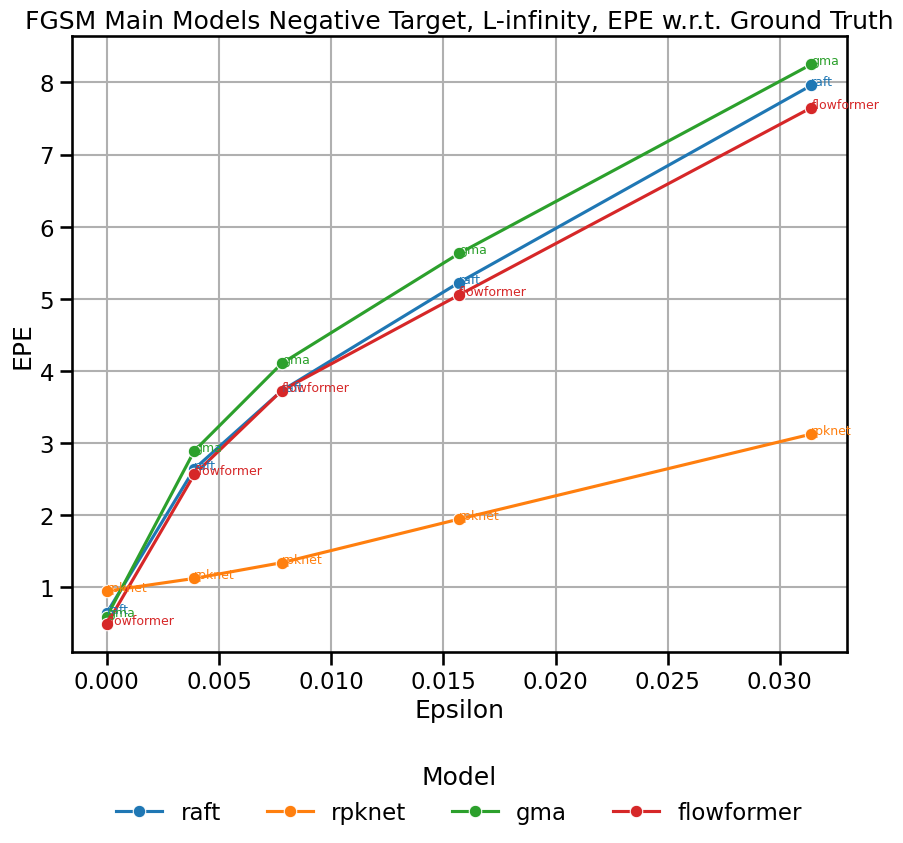

In [21]:
def plot_line(data, title, filename):
    # Create the plot
    plt.figure(figsize=(10, 8))
    line_plot = sns.lineplot(data=data, x='epsilon', y='epe_ground_truth', hue='model', marker='o')

     # Customize the plot
    plt.xlabel('Epsilon')
    plt.ylabel('EPE')
    plt.grid(True)
    plt.title(title)

    # Add annotations
    # Get colors from the legend
    handles, labels = line_plot.get_legend_handles_labels()
    legend_colors = dict(zip(labels, [handle.get_color() for handle in handles]))

    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        for i in range(model_data.shape[0]):
            plt.text(model_data['epsilon'].iloc[i], model_data['epe_ground_truth'].iloc[i], model, fontsize=9, color=legend_colors[model])

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti' or (attack == 'none' and checkpoint == 'kitti')")
plot_line(data_target_zero, "FGSM All Models Zero Target, L-infinity, EPE w.r.t. Ground Truth", 'graphs/FGSM All Models Zero Target INF epe to gt.png')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti' or (attack == 'none' and checkpoint == 'kitti')")
plot_line(data_target_negative, "FGSM All Models Negative Target, L-infinity, EPE w.r.t. Ground Truth", 'graphs/FGSM All Models Negative Target INF epe to gt.png')

specific_models = ['raft', 'pwcnet', 'gma', 'flownet2', 'flowformer', 'rpknet']


# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_line(data_specific_models_target_zero, "FGSM Main Models Zero Target, L-infinity, EPE w.r.t. Ground Truth", 'graphs/FGSM Main Models Zero Target INF epe to gt.png')

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_line(data_specific_models_target_negative, "FGSM Main Models Negative Target, L-infinity, EPE w.r.t. Ground Truth", 'graphs/FGSM Main Models Negative Target INF epe to gt.png')


#### FGSM ALL + MAIN MODELS TWO NORM

/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


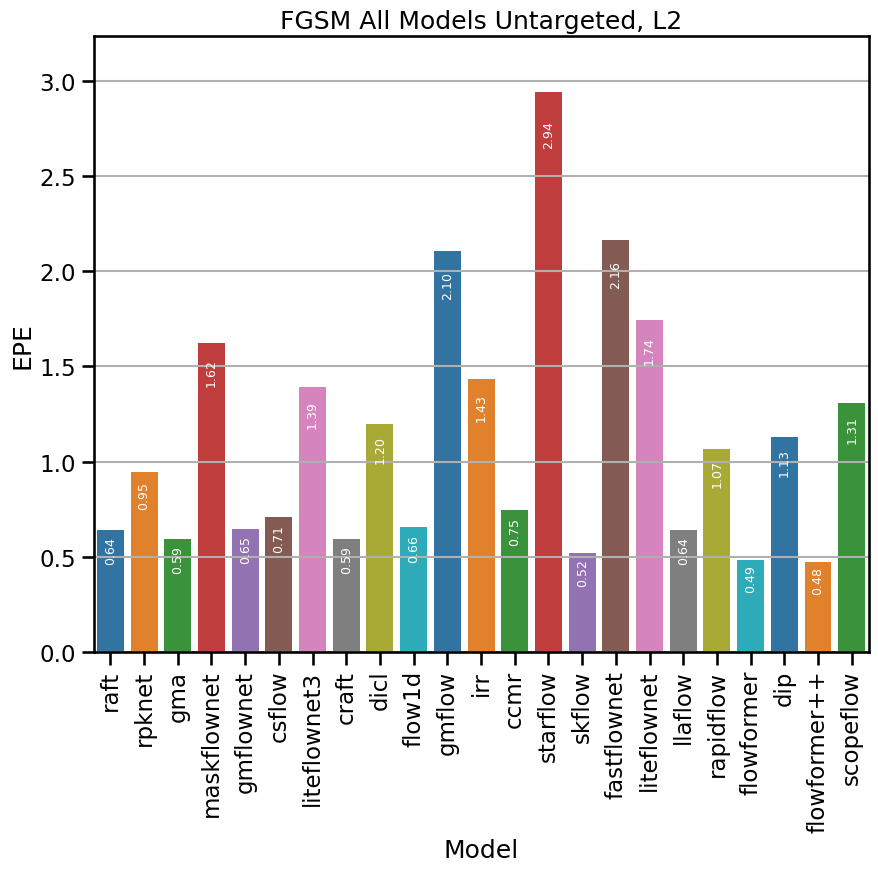

/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


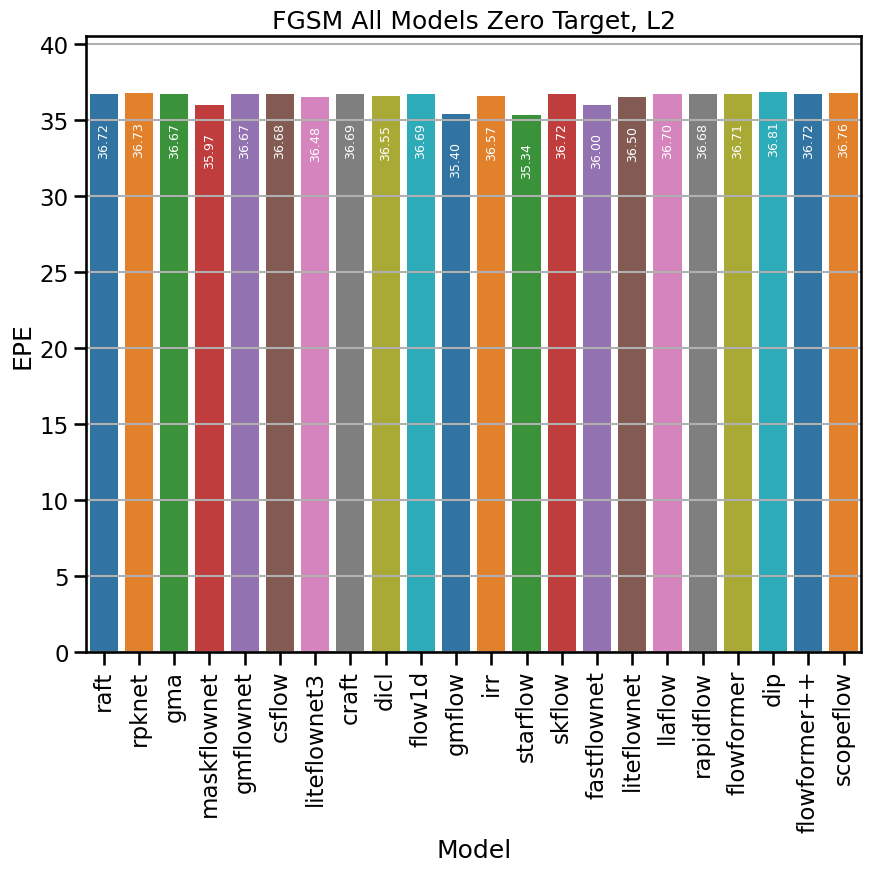

/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


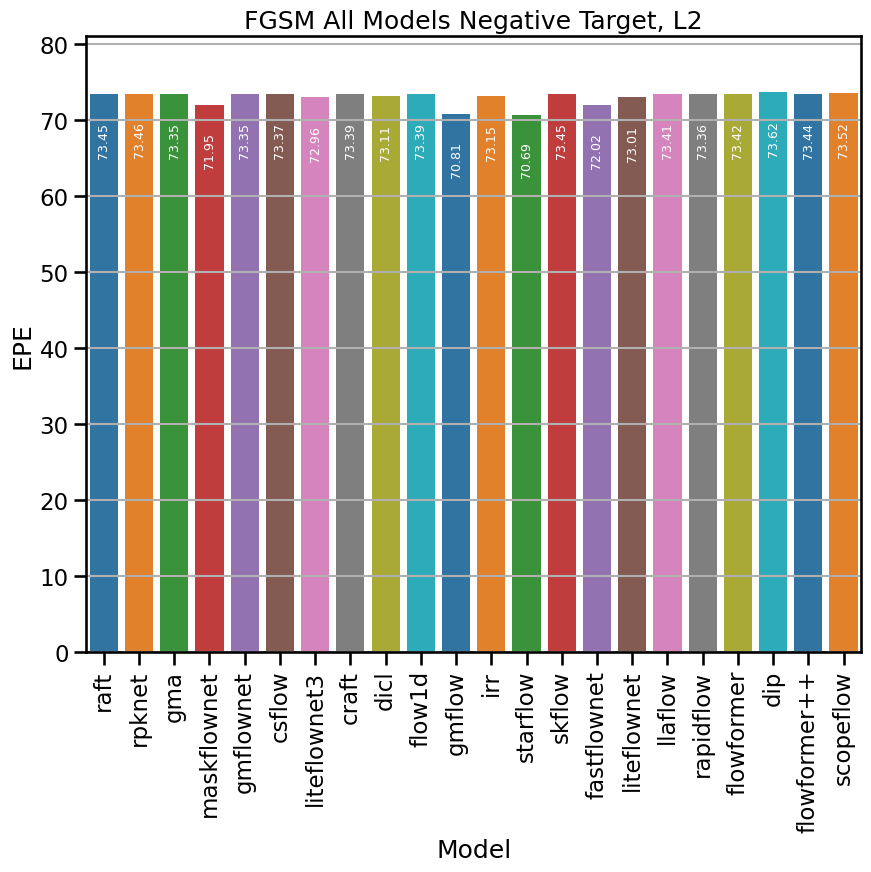

/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


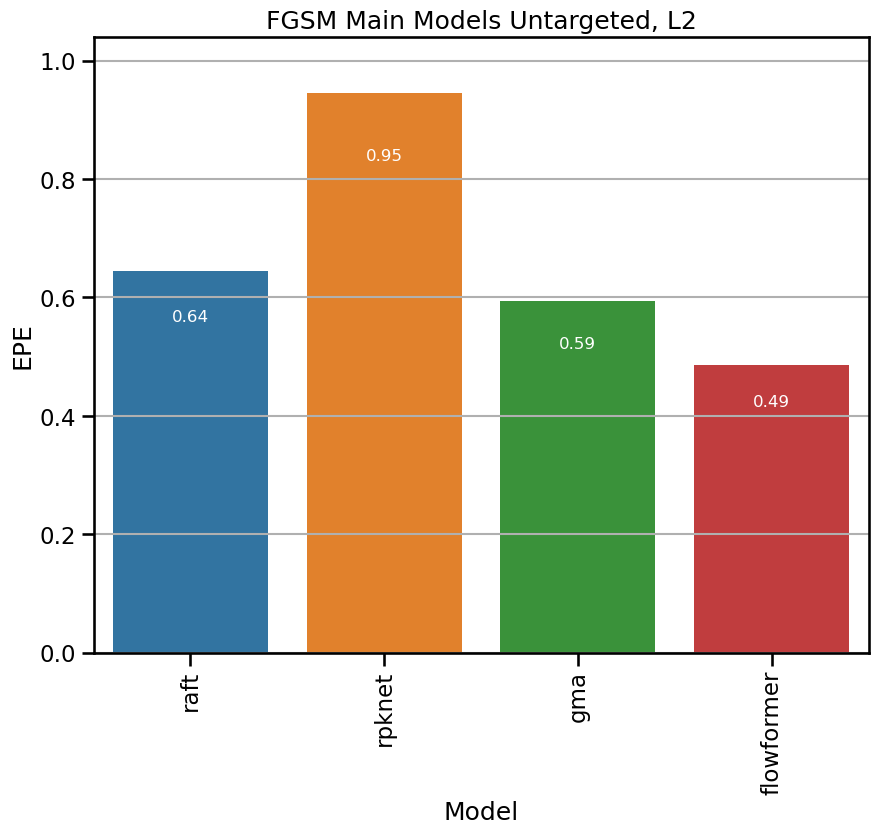

/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


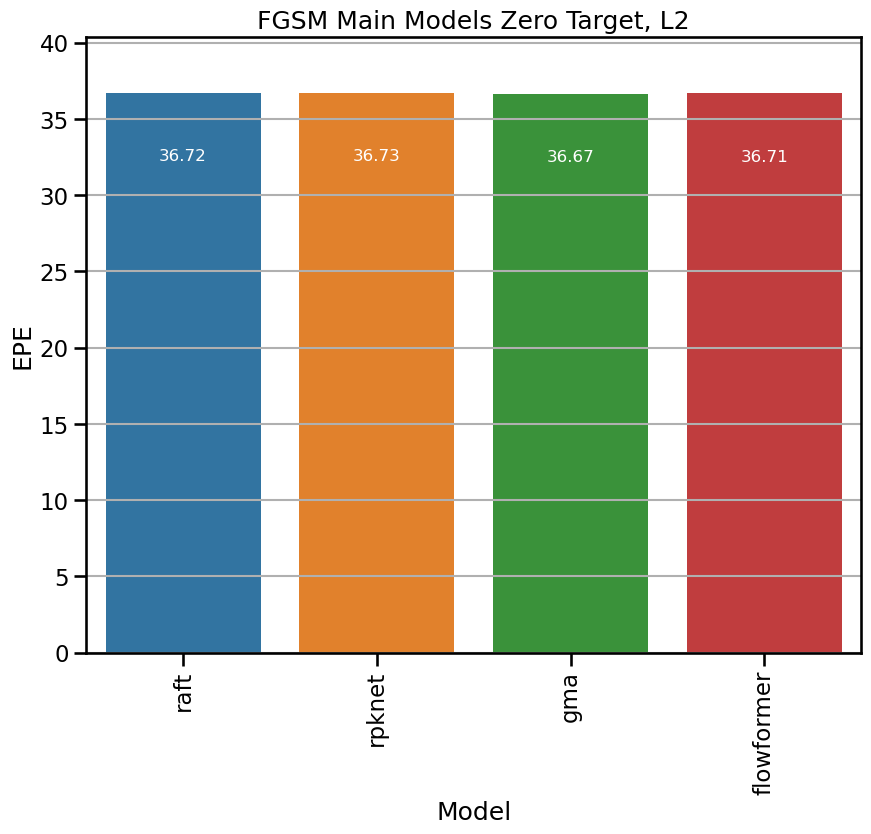

/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2988502764.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


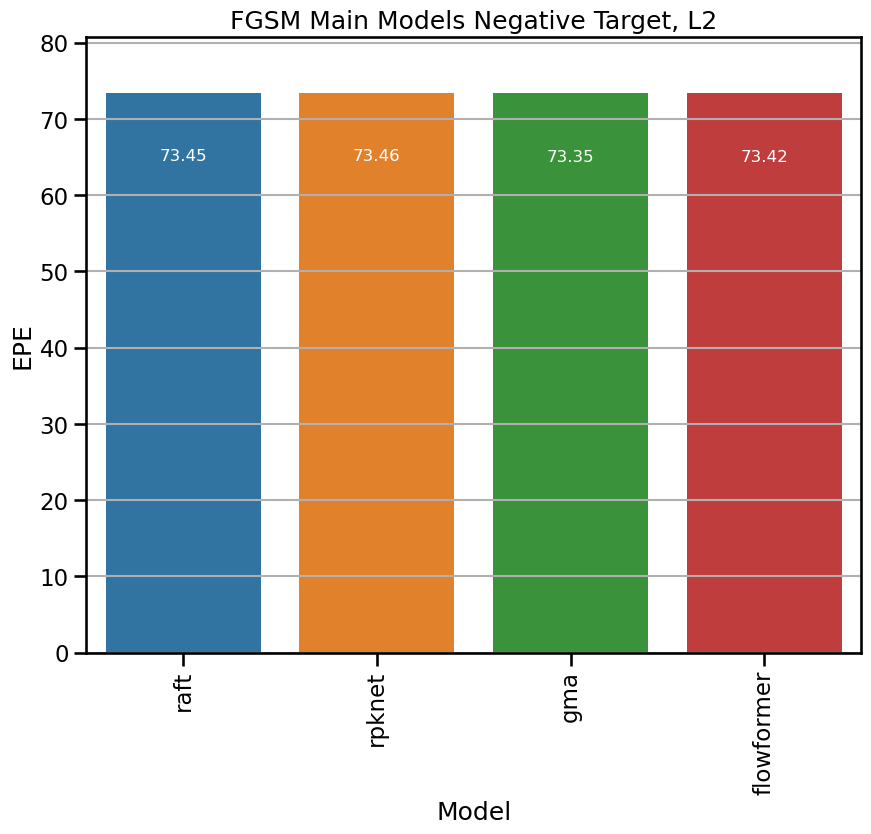

In [22]:
def plot_data(data, title, filename, specific_models=False):
    # Create the plot
    plt.figure(figsize=(10, 8))
    bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')

    # Customize the plot
    plt.xlabel('Model')
    plt.ylabel('EPE')
    plt.title(title)
    plt.grid(True, axis='y')

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation=90)

    # Annotate each bar with the y value within the bar at the top
    for bar in bar_plot.patches:
        bar_height = bar.get_height()
        if specific_models:
            bar_plot.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height - bar_height * 0.10,  # Adjusted for better alignment
                f'{bar_height:.2f}',
                ha='center',
                va='top',
                rotation=0,  # Horizontal text
                color='white',
                fontsize=12  # Larger font size
            )
        else:
            bar_plot.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height - bar_height * 0.05,
                f'{bar_height:.2f}',
                ha='center',
                va='top',
                rotation=90,  # Vertical text
                color='white',
                fontsize=9
            )

    # Adjust y-axis limit to make sure the annotations fit within the frame
    max_epe = data['epe'].max()
    plt.ylim(0, max_epe * 1.1)

    # Show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot for untargeted attack
data_untargeted = df.query("attack == 'fgsm' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_untargeted, "FGSM All Models Untargeted, L2", 'graphs/FGSM All Models Untargeted 2-Norm.png')

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_zero, "FGSM All Models Zero Target, L2", 'graphs/FGSM All Models Zero Target 2-Norm.png')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'fgsm' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_negative, "FGSM All Models Negative Target, L2", 'graphs/FGSM All Models Negative Target 2-Norm.png')

specific_models = ['raft', 'pwcnet', 'gma', 'flownet2', 'flowformer', 'rpknet']

# Plot for untargeted attack with specific models
data_specific_models_untargeted = data_untargeted[data_untargeted['model'].isin(specific_models)]
plot_data(data_specific_models_untargeted, "FGSM Main Models Untargeted, L2", 'graphs/FGSM Main Models Untargeted 2-Norm.png', specific_models=True)

# Plot for targeted attack with target zero and specific models
data_specific_models_target_zero = data_target_zero[data_target_zero['model'].isin(specific_models)]
plot_data(data_specific_models_target_zero, "FGSM Main Models Zero Target, L2", 'graphs/FGSM Main Models Zero Target 2-Norm.png', specific_models=True)

# Plot for targeted attack with negative target and specific models
data_specific_models_target_negative = data_target_negative[data_target_negative['model'].isin(specific_models)]
plot_data(data_specific_models_target_negative, "FGSM Main Models Negative Target, L2", 'graphs/FGSM Main Models Negative Target 2-Norm.png', specific_models=True)


#### BIM/PGD/CosPGD ALL Models INF



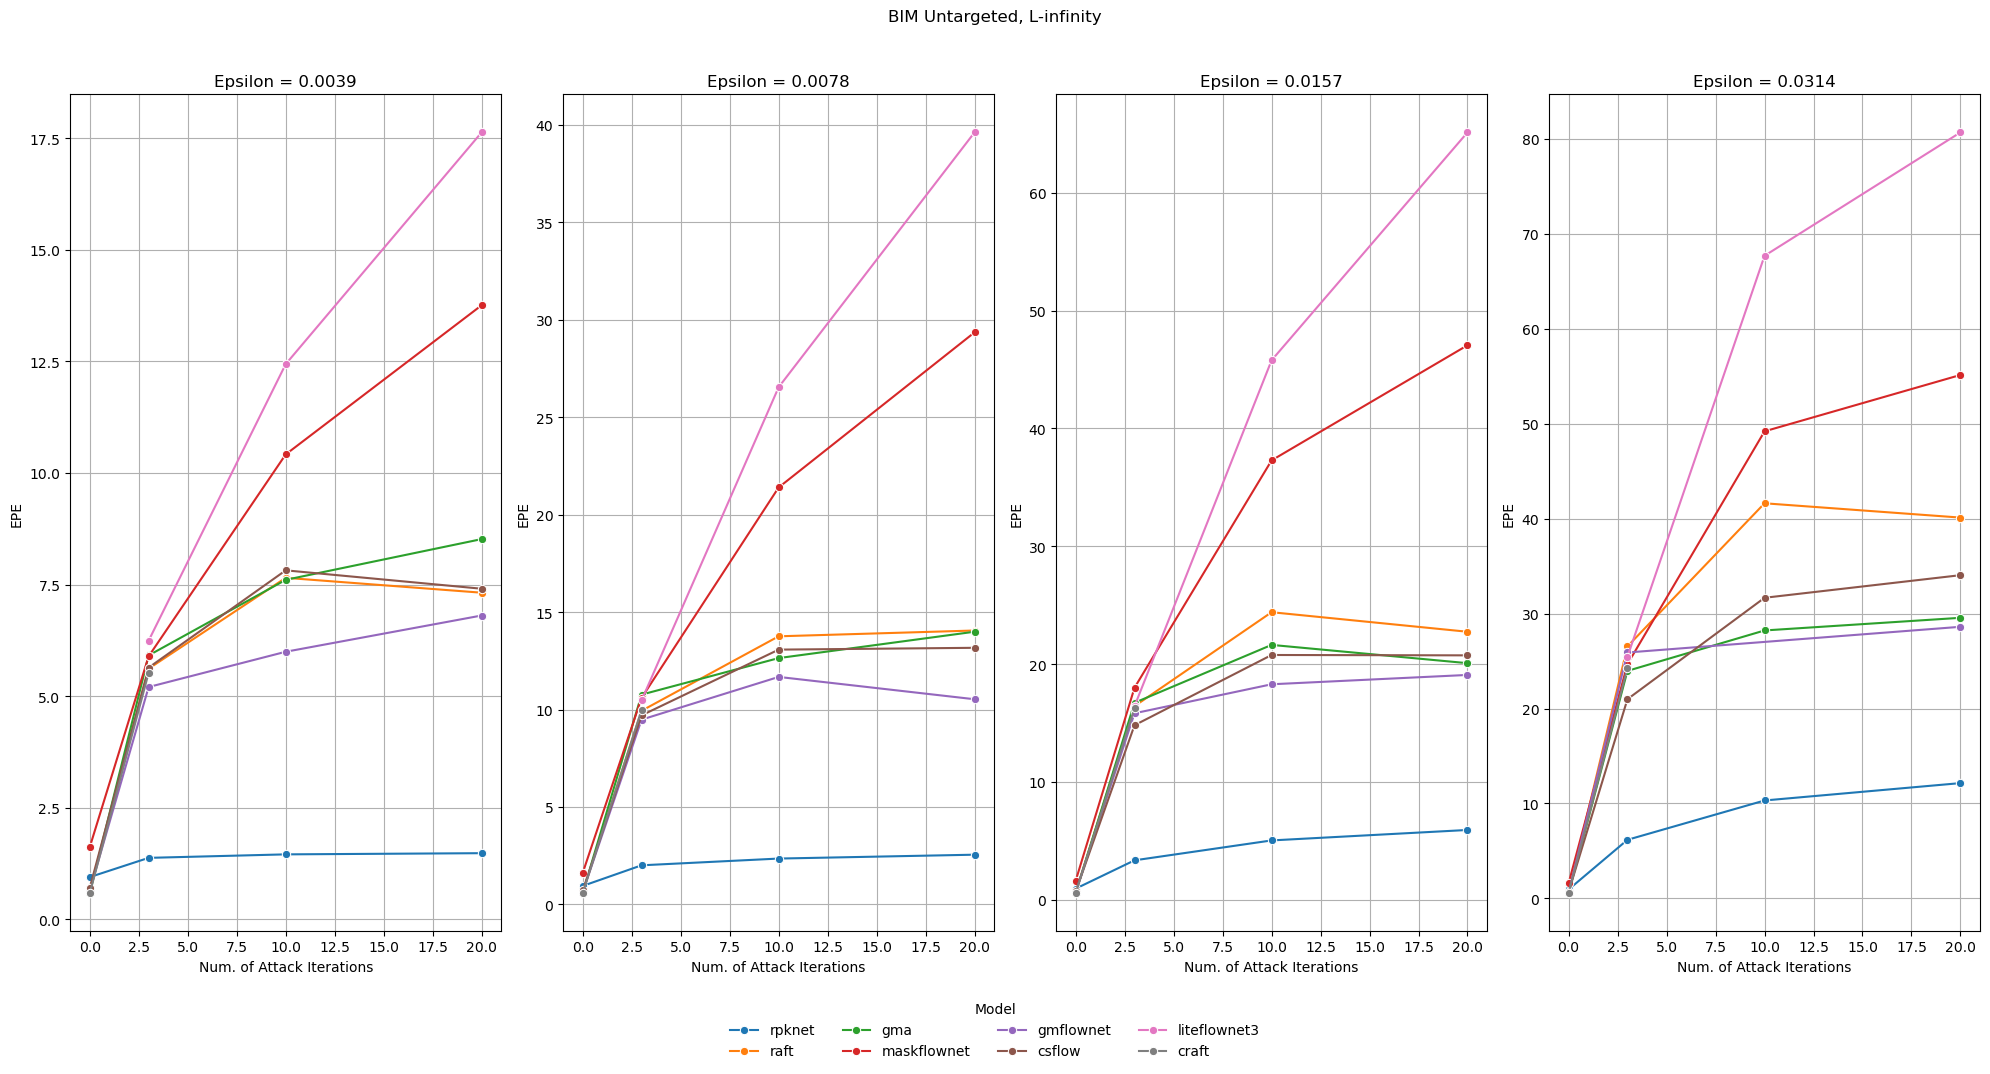

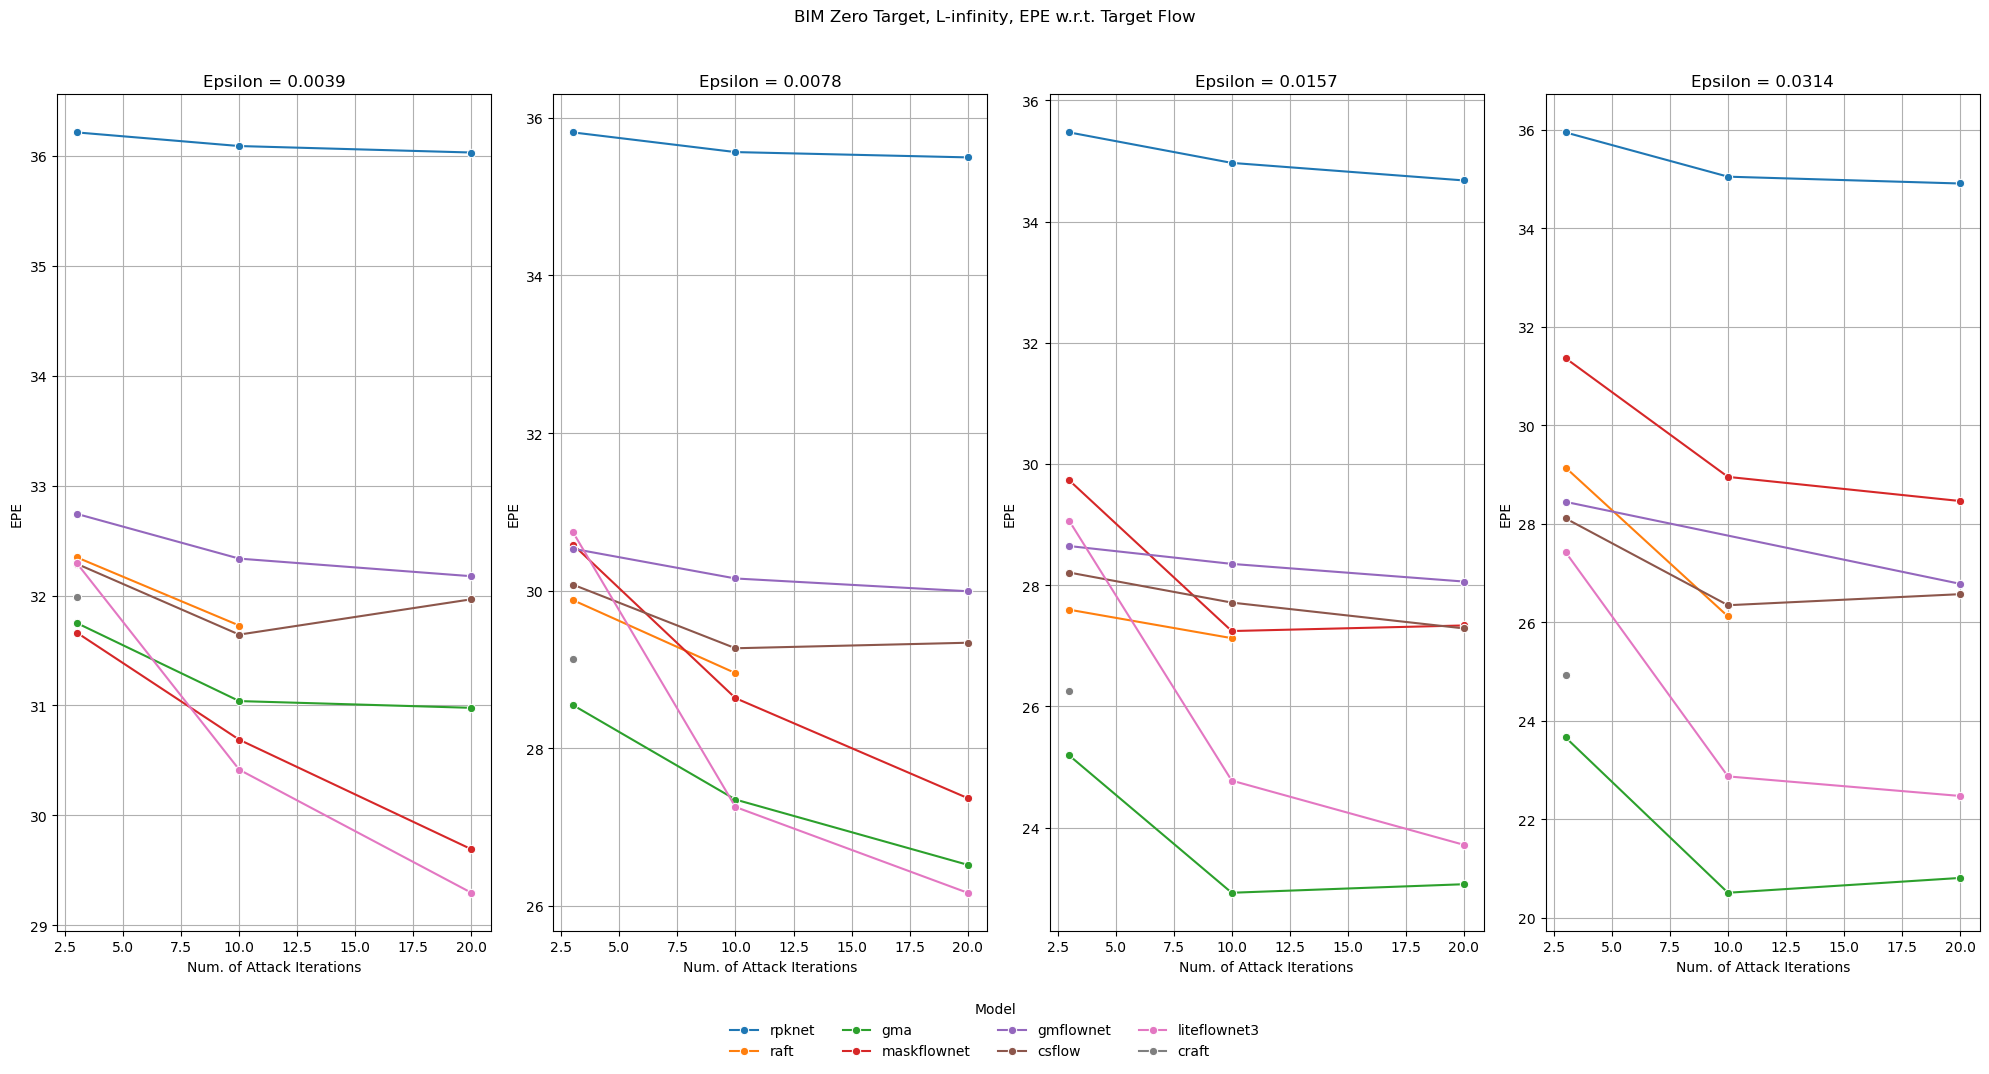

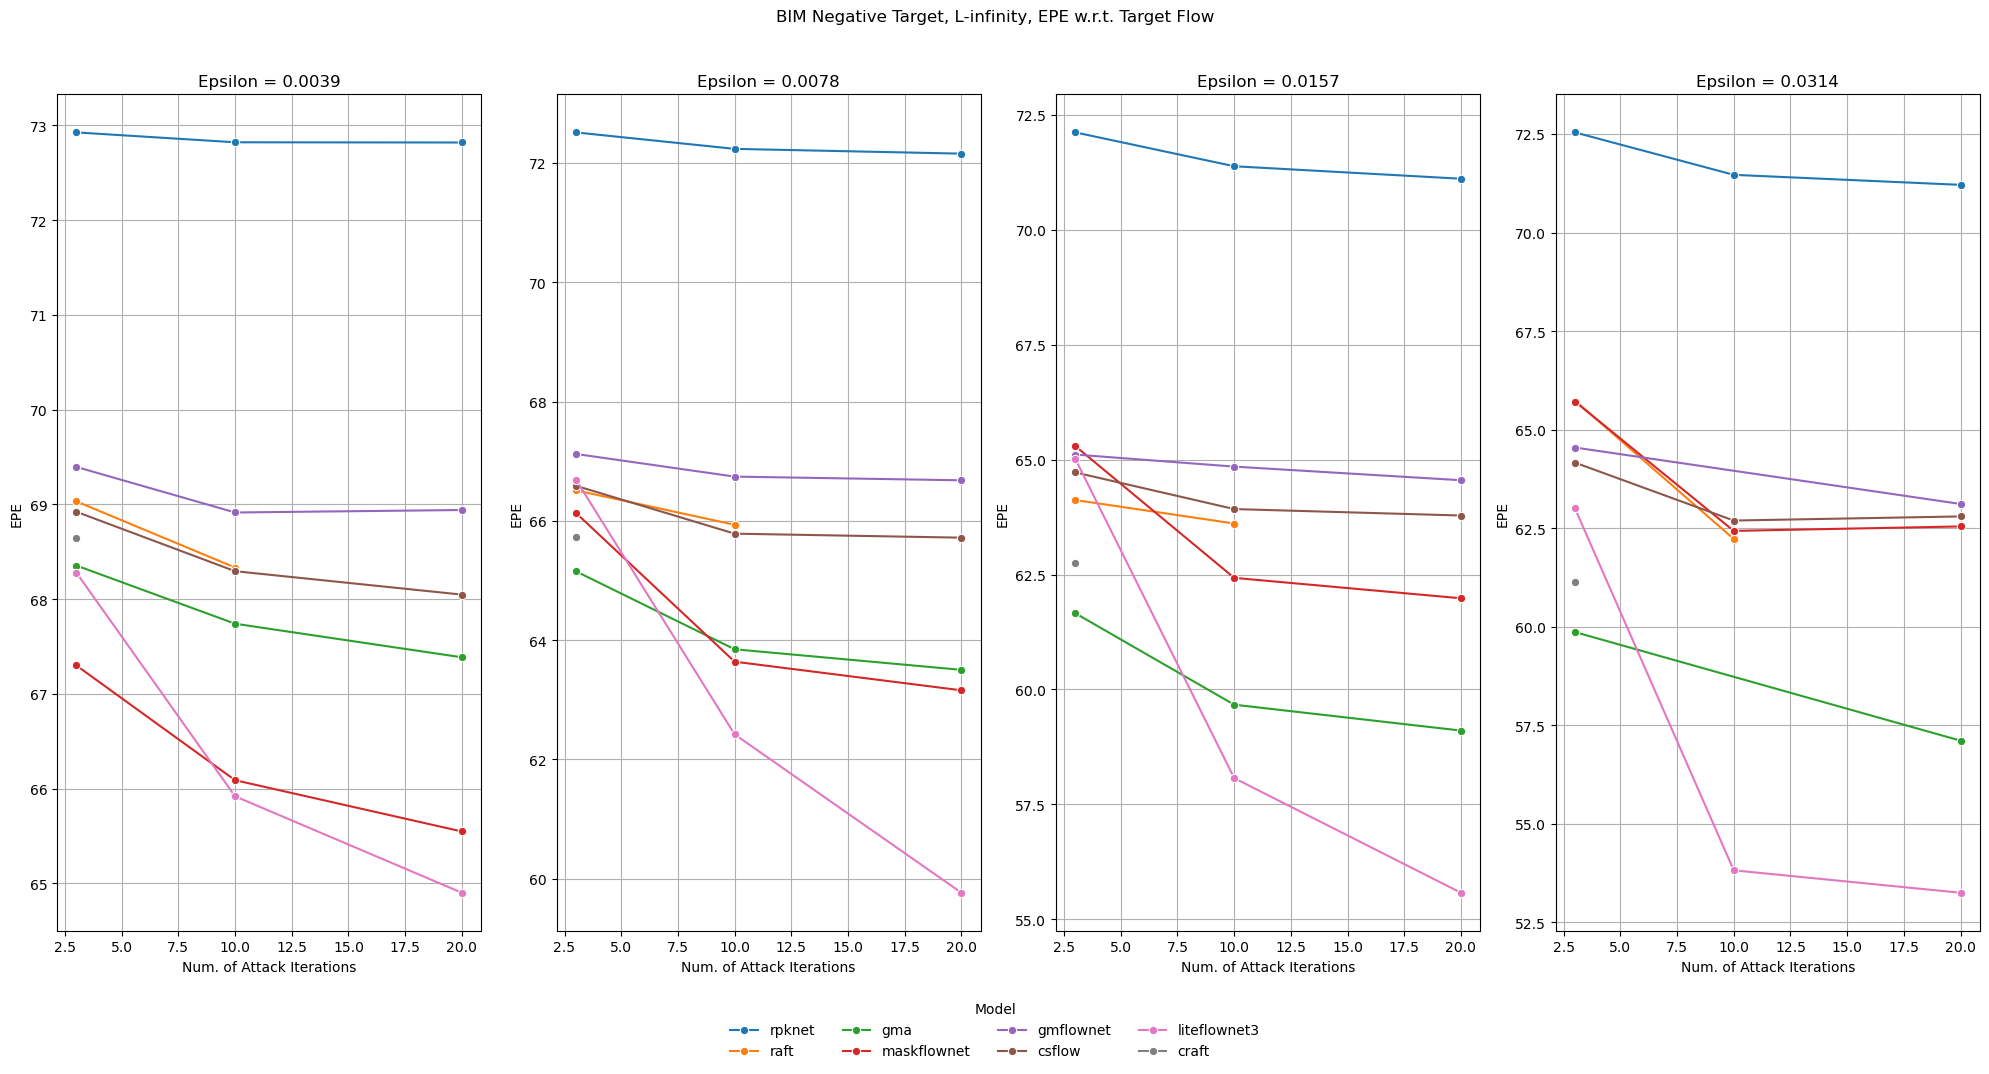

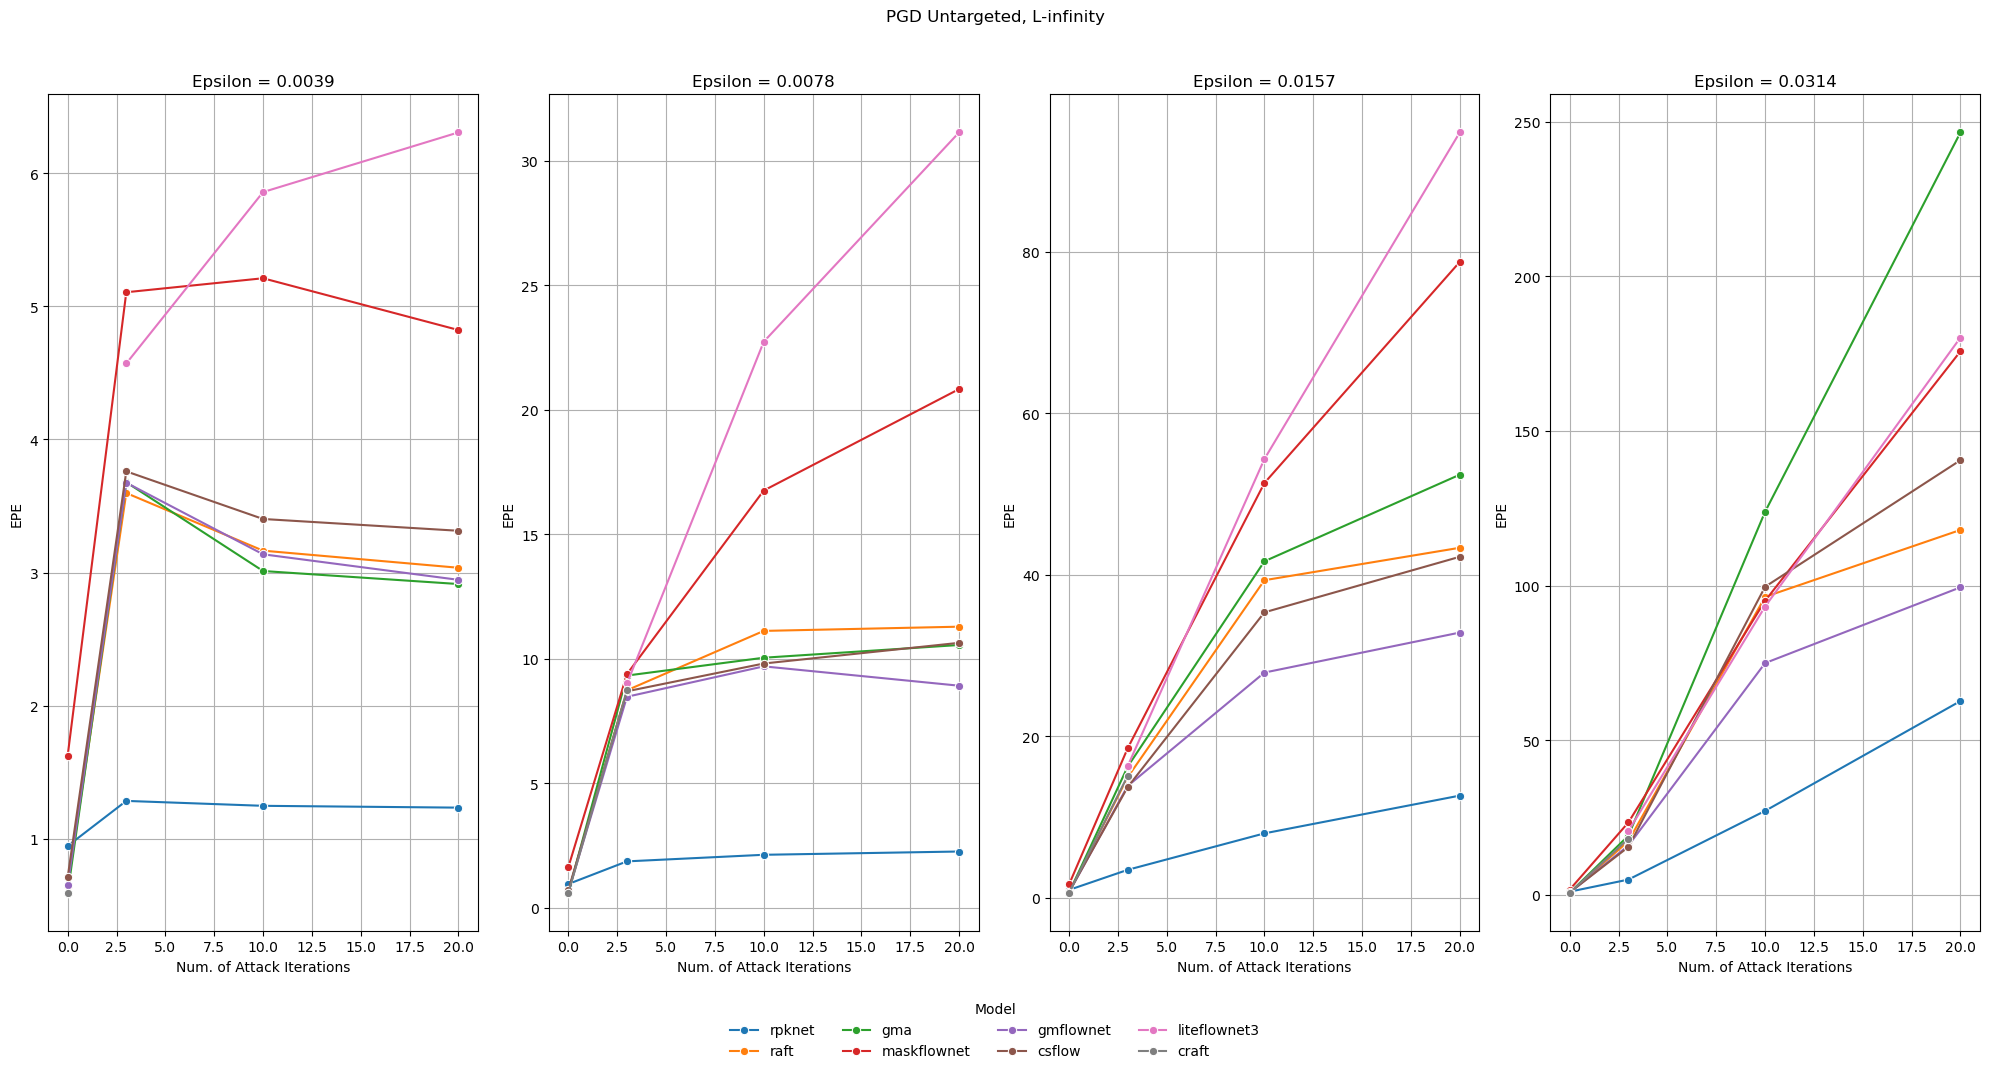

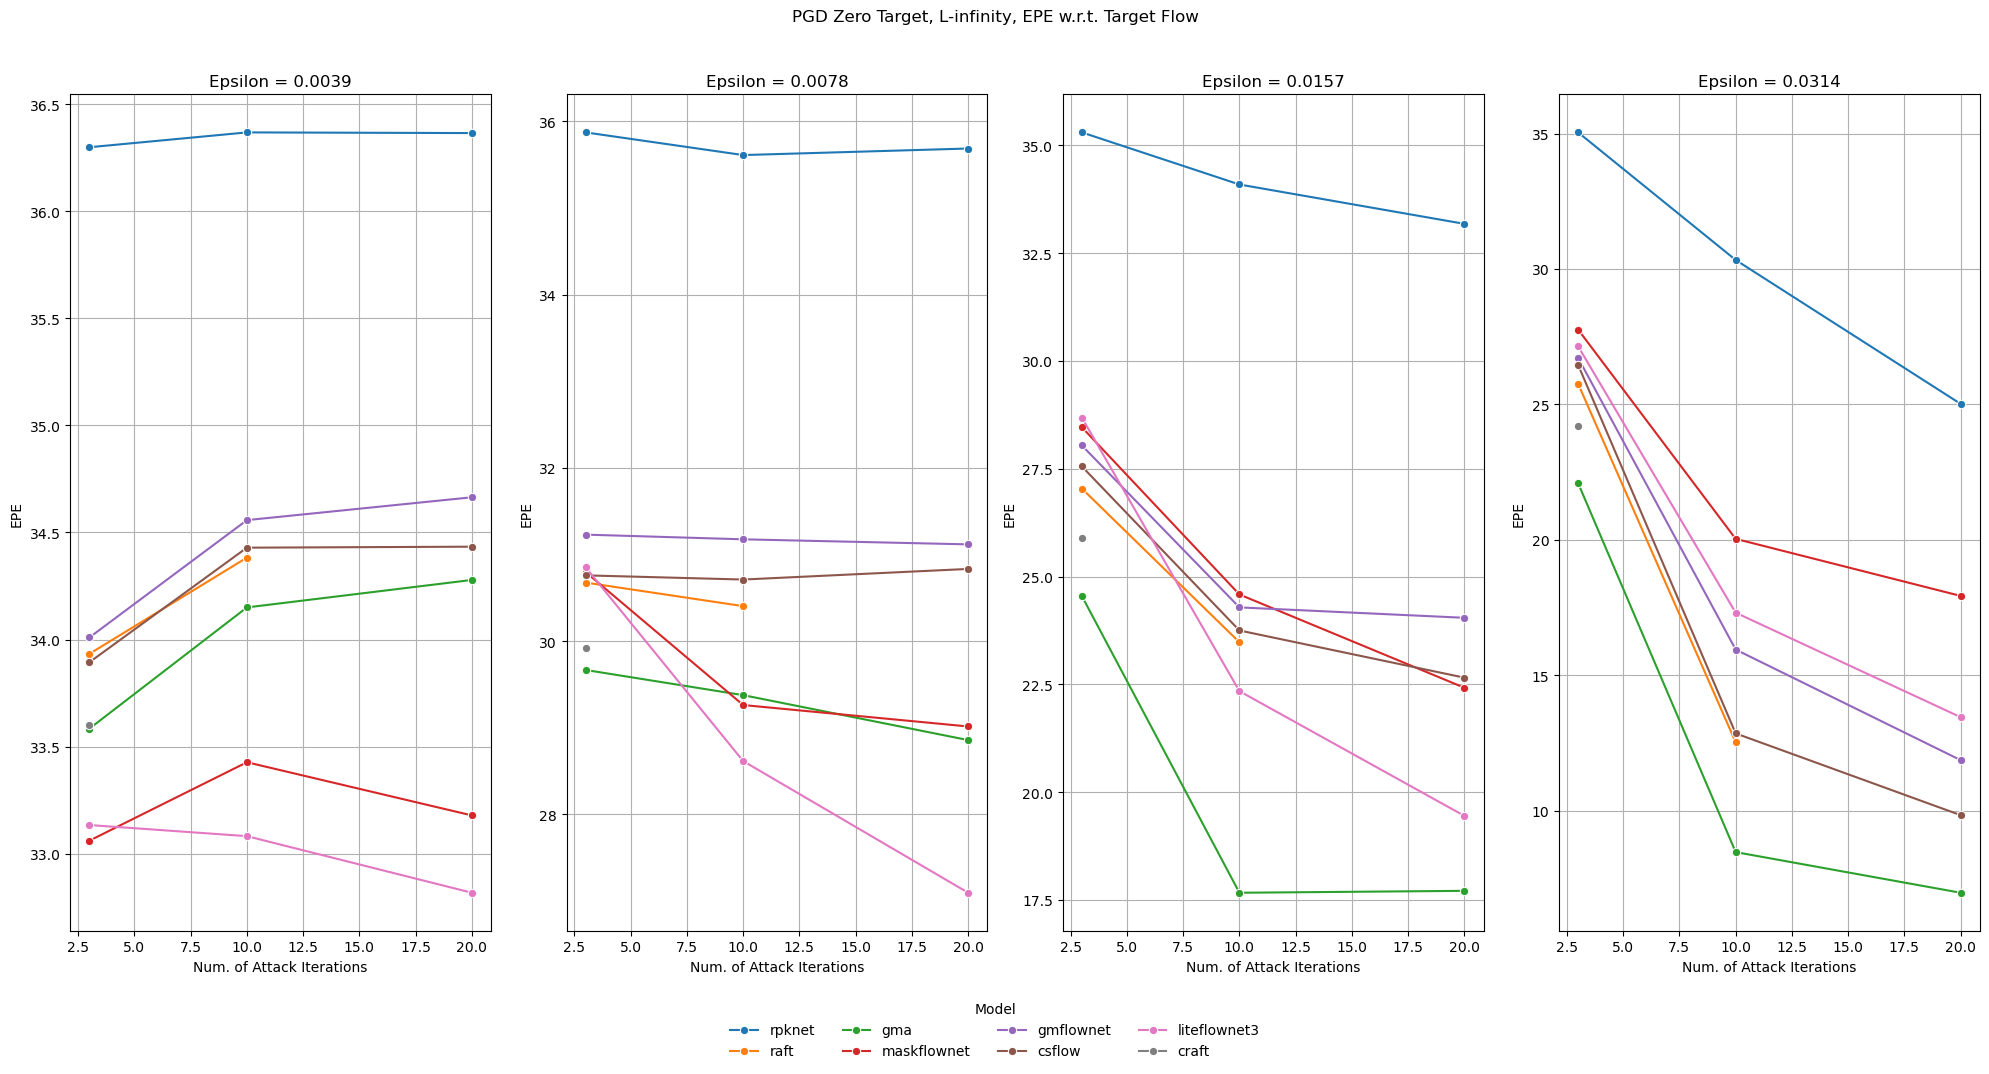

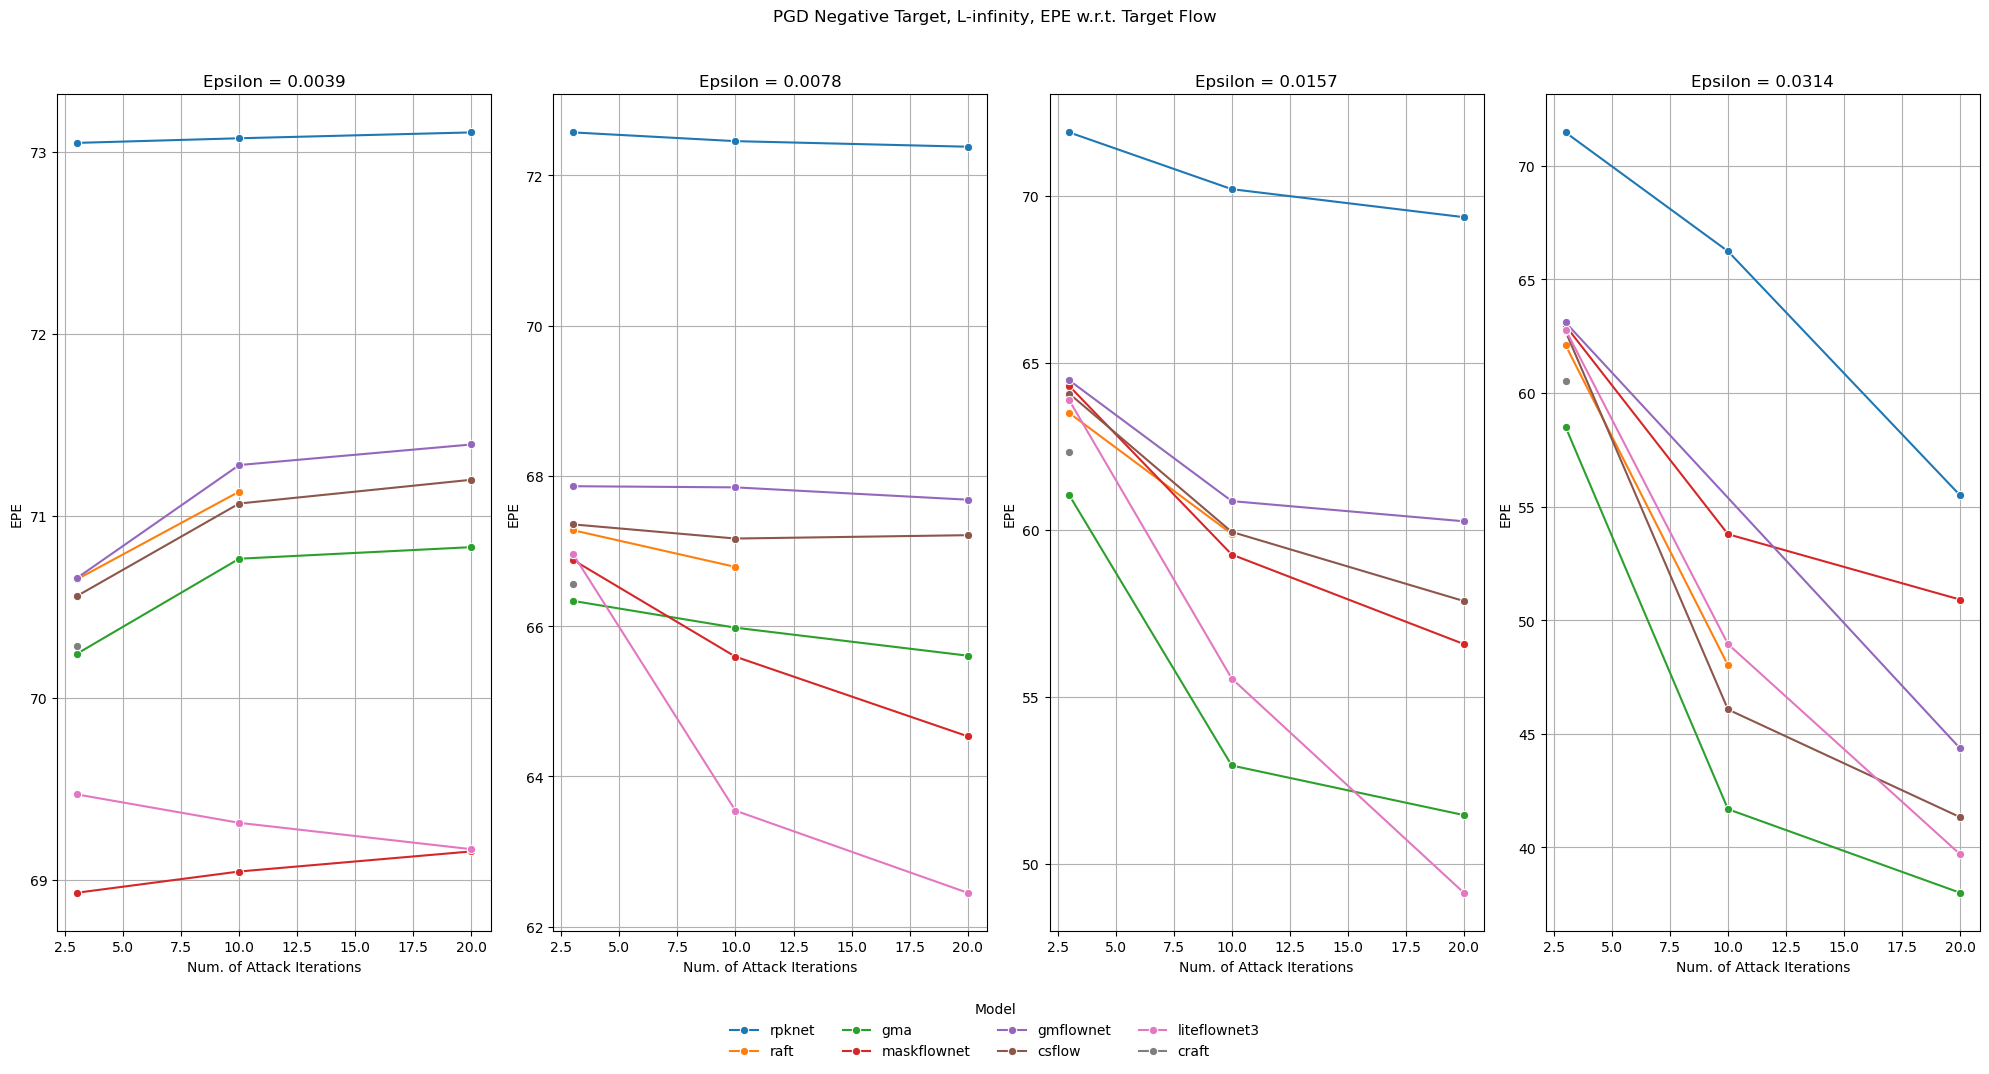

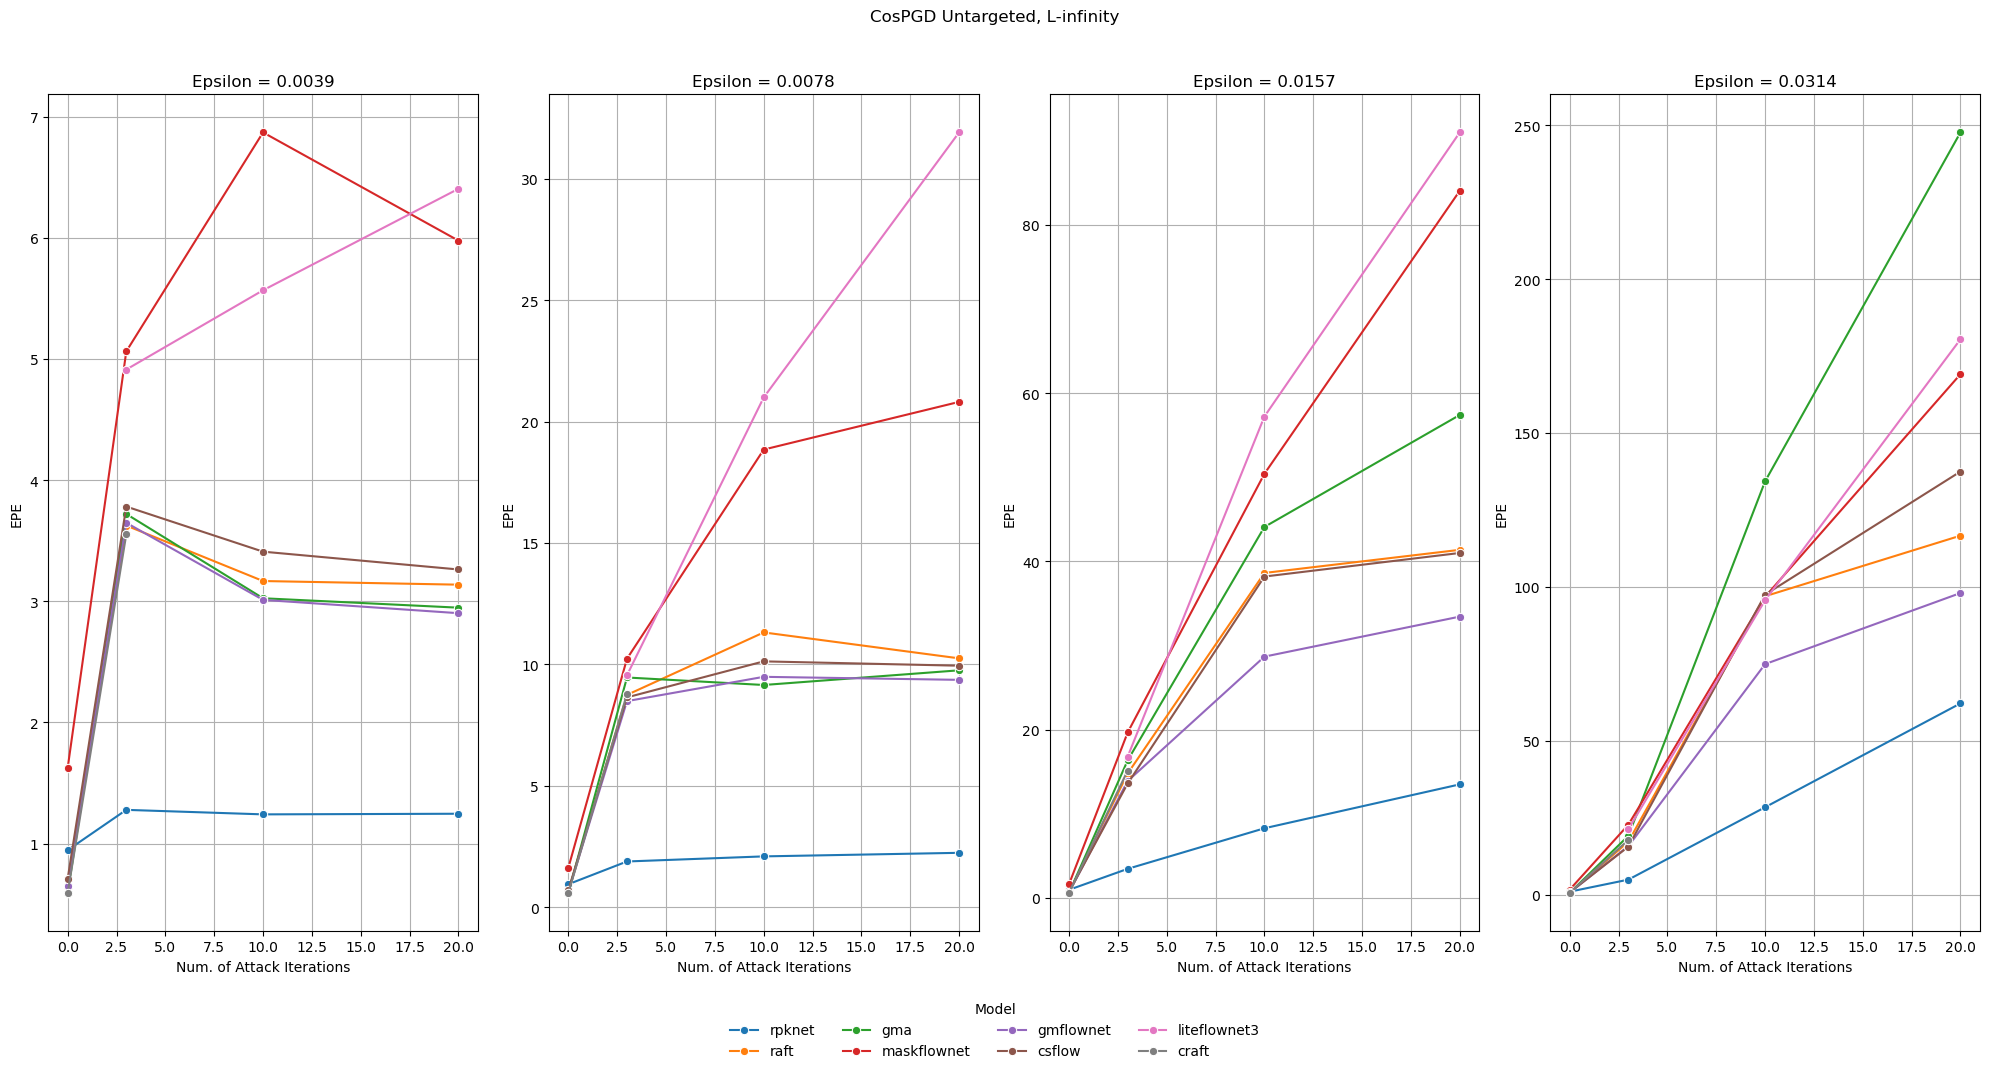

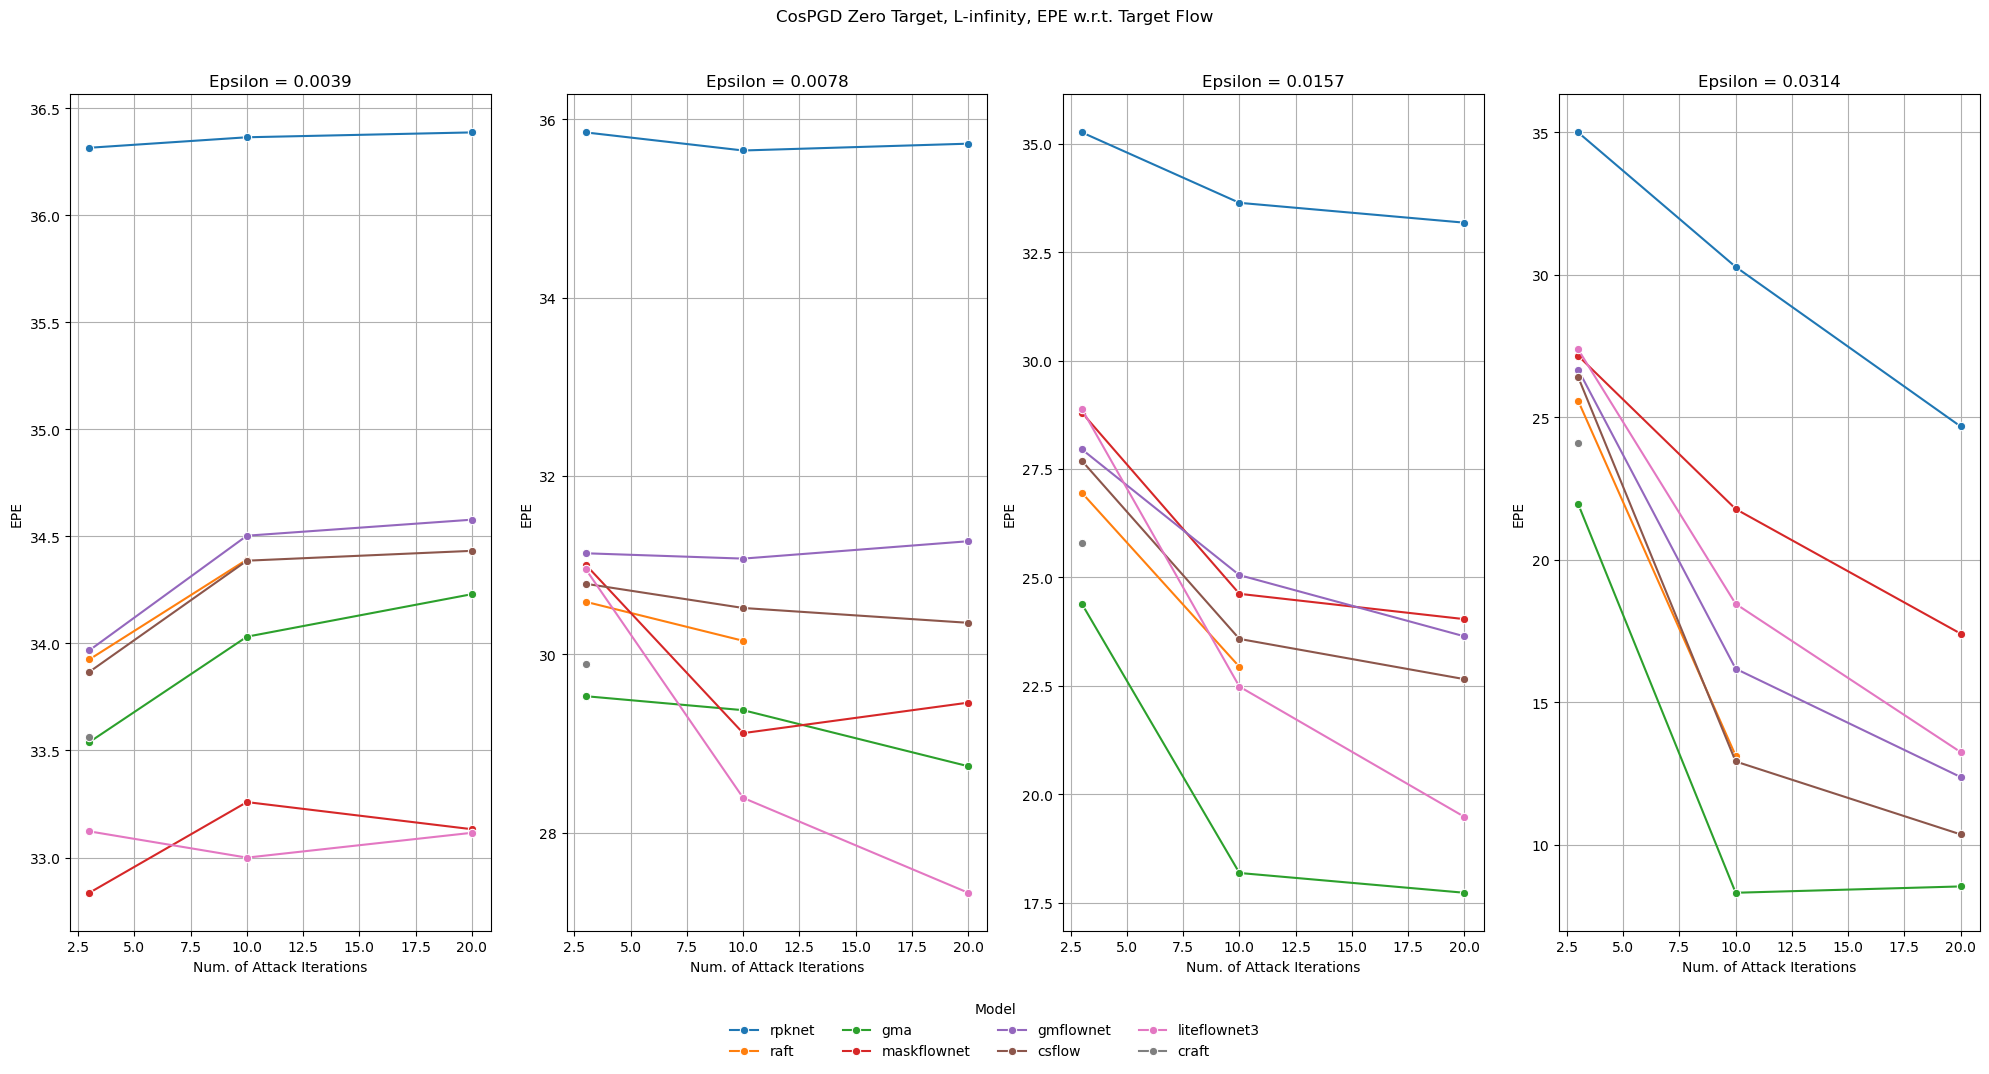

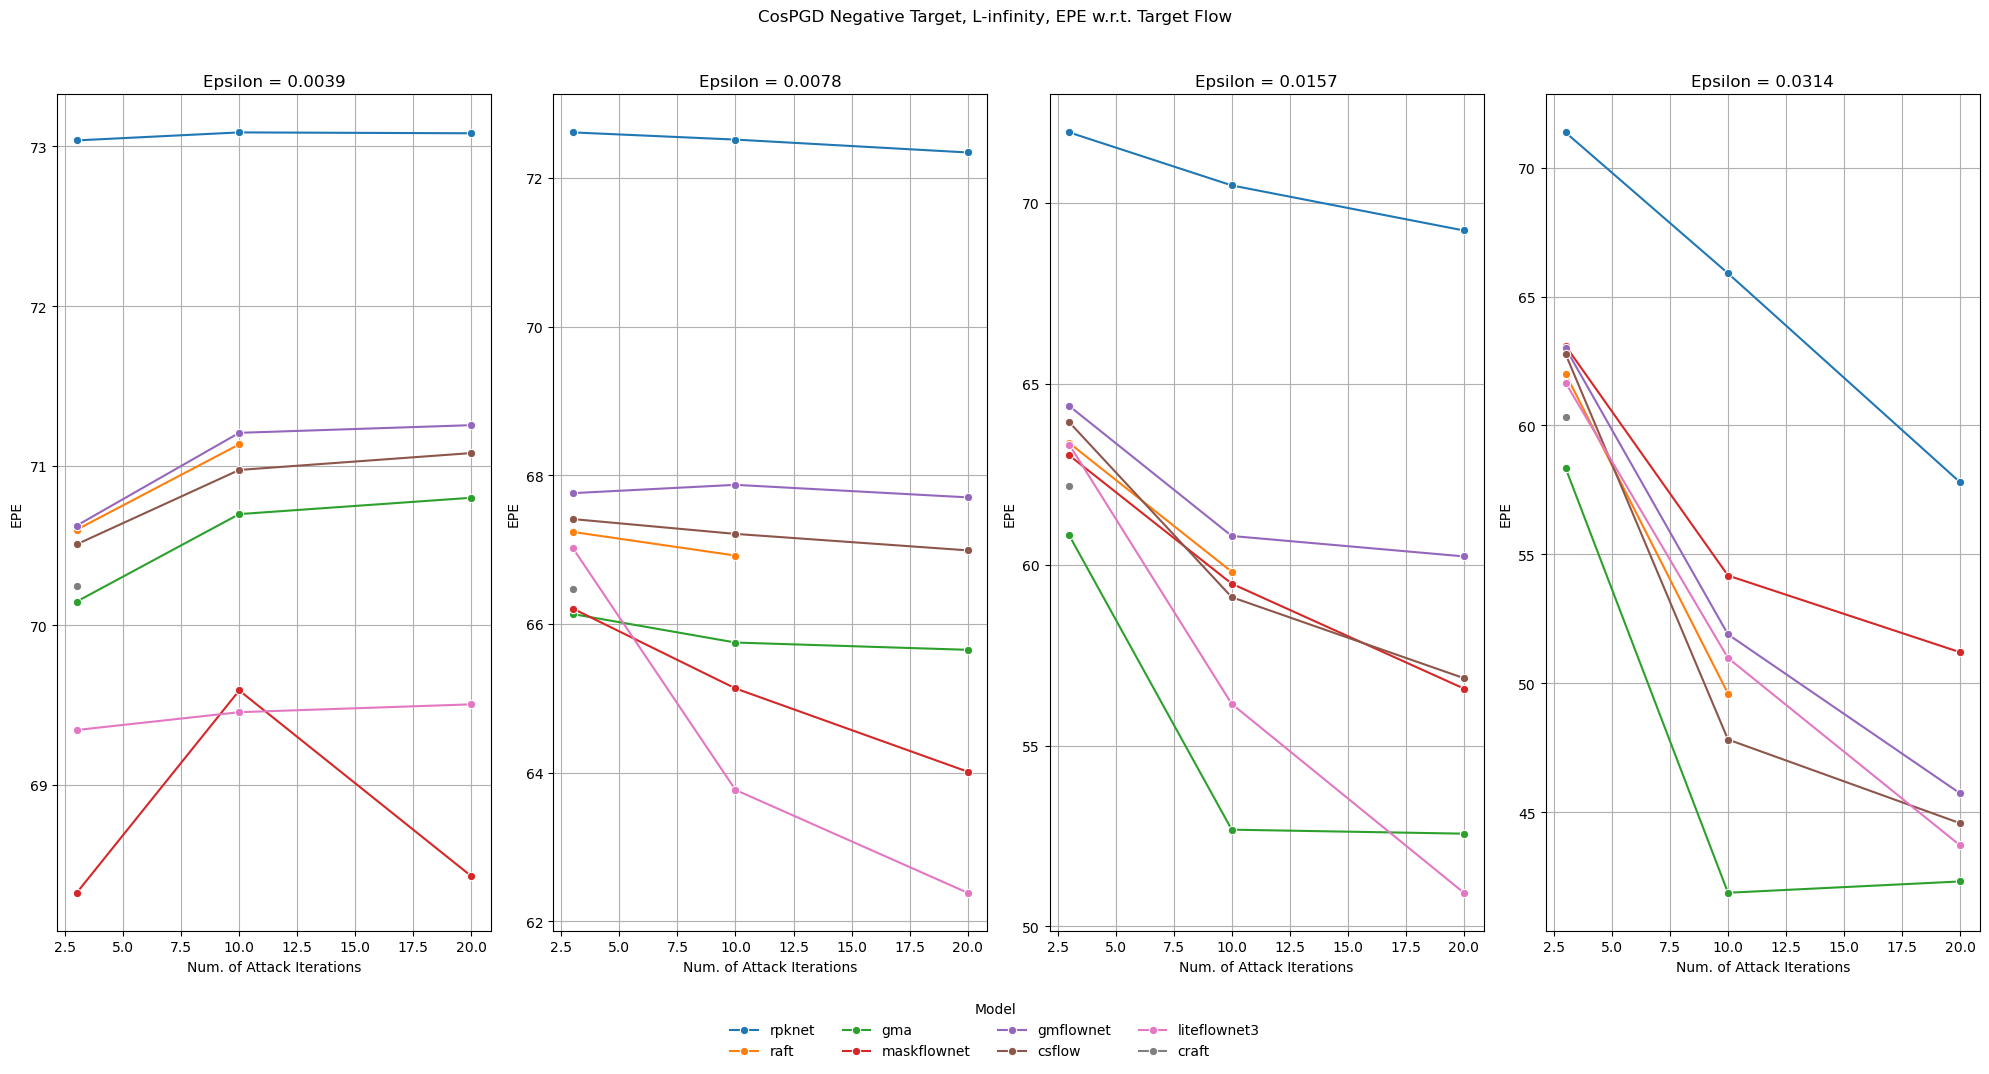

In [4]:
def plot_bim(data, title, filename, epsilon_values):
    num_epsilon = len(epsilon_values)
    fig, axes = plt.subplots(1, num_epsilon, figsize=(5 * num_epsilon, 10))
    fig.suptitle(title)

    if num_epsilon == 1:
        axes = [axes]

    for ax, epsilon in zip(axes, epsilon_values):
        # Create the plot for each epsilon
        sns.lineplot(data=data.query(f"epsilon == {epsilon} or epsilon == 0"), x='iterations', y='epe', hue='model', marker='o', ax=ax)
        ax.set_title(f'Epsilon = {epsilon}')
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE')
        ax.grid(True)

    # Remove individual legends by setting legend to False in sns.lineplot
    for ax in axes:
        ax.legend().remove()

    # Adjust the legend position and add it to the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title and legend
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

### BIM ###

# Plot for untargeted attack
query = "attack == 'bim' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_untargeted_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_untargeted_inf, 'BIM Untargeted, L-infinity', 'graphs/BIM Untargeted Inf Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with target zero
data_target_zero_inf = df.query("attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_bim(data_target_zero_inf, 'BIM Zero Target, L-infinity, EPE w.r.t. Target Flow', 'graphs/BIM Zero Target Inf-Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with negative target
data_target_negative_inf = df.query("attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_bim(data_target_negative_inf, 'BIM Negative Target, L-infinity, EPE w.r.t. Target Flow', 'graphs/BIM Negative Target Inf-Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])


### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_untargeted_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_untargeted_inf, 'PGD Untargeted, L-infinity', 'graphs/PGD Untargeted Inf Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with target zero
data_target_zero_inf = df.query("attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_bim(data_target_zero_inf, 'PGD Zero Target, L-infinity, EPE w.r.t. Target Flow', 'graphs/PGD Zero Target Inf-Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with negative target
data_target_negative_inf = df.query("attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_bim(data_target_negative_inf, 'PGD Negative Target, L-infinity, EPE w.r.t. Target Flow', 'graphs/PGD Negative Target Inf-Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_untargeted_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_untargeted_inf, 'CosPGD Untargeted, L-infinity', 'graphs/CosPGD Untargeted Inf Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with target zero
data_target_zero_inf = df.query("attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_bim(data_target_zero_inf, 'CosPGD Zero Target, L-infinity, EPE w.r.t. Target Flow', 'graphs/CosPGD Zero Target Inf-Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with negative target
data_target_negative_inf = df.query("attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_bim(data_target_negative_inf, 'CosPGD Negative Target, L-infinity, EPE w.r.t. Target Flow', 'graphs/CosPGD Negative Target Inf-Norm.png', [0.0039, 0.0078, 0.0157, 0.0314])

#### BIM/PGD/CosPGD ALL Models L-infinity, w.r.t. Ground Truth

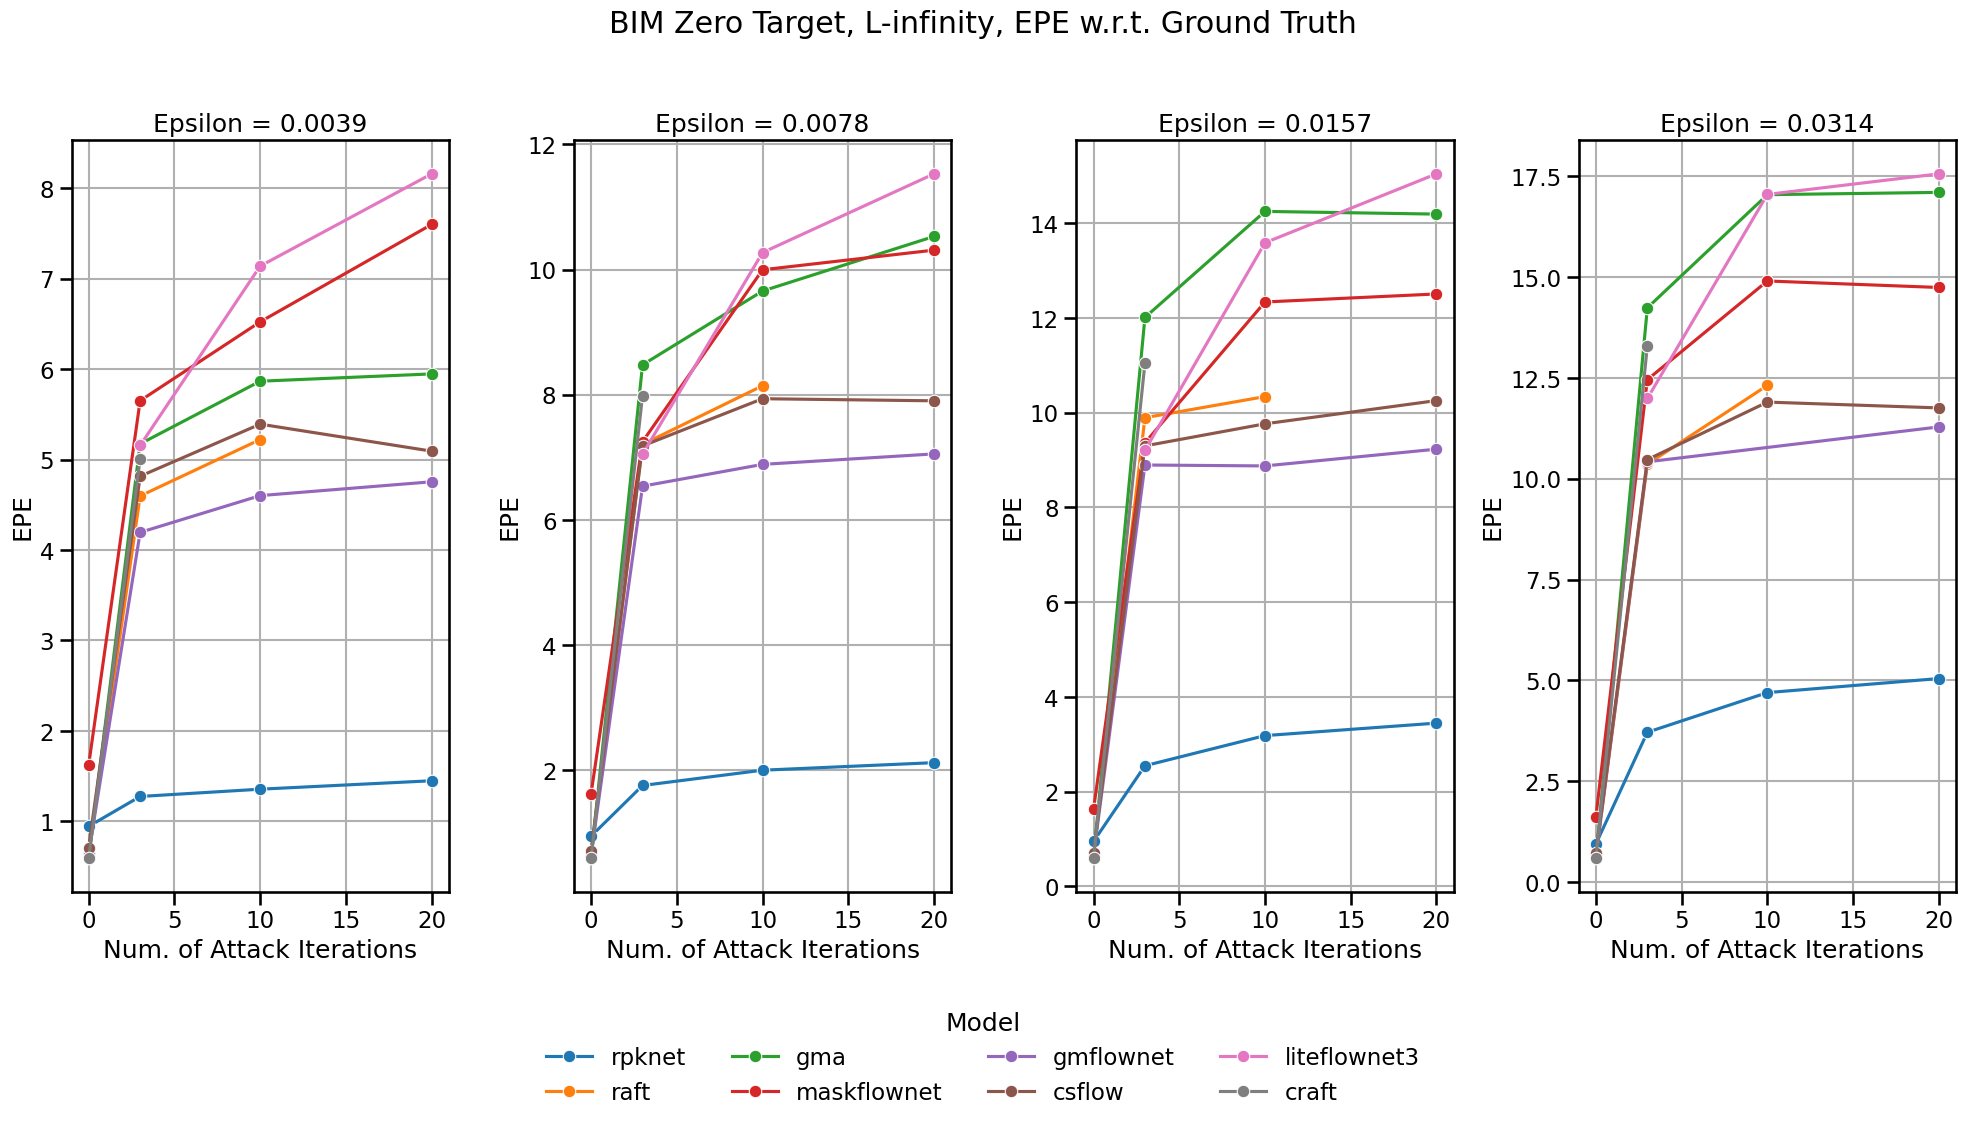

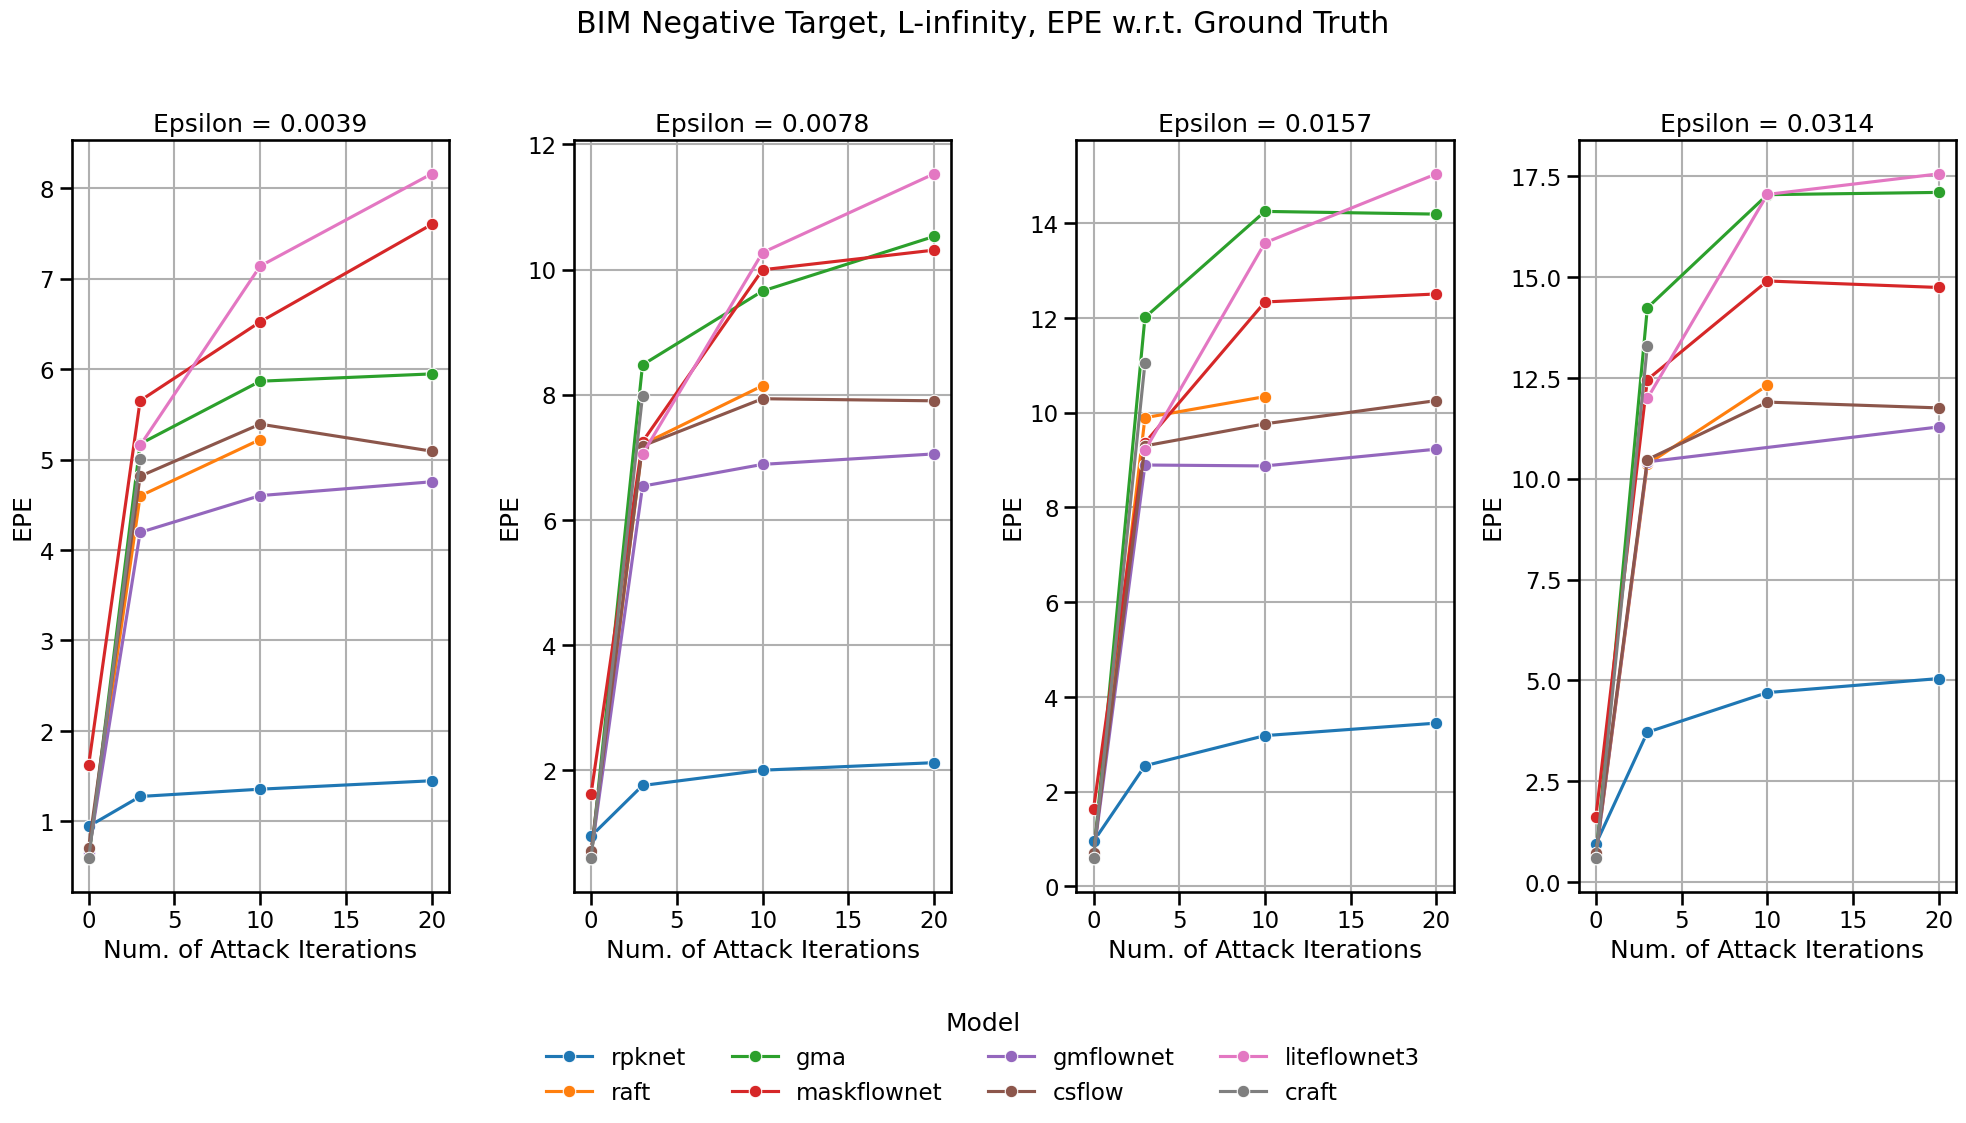

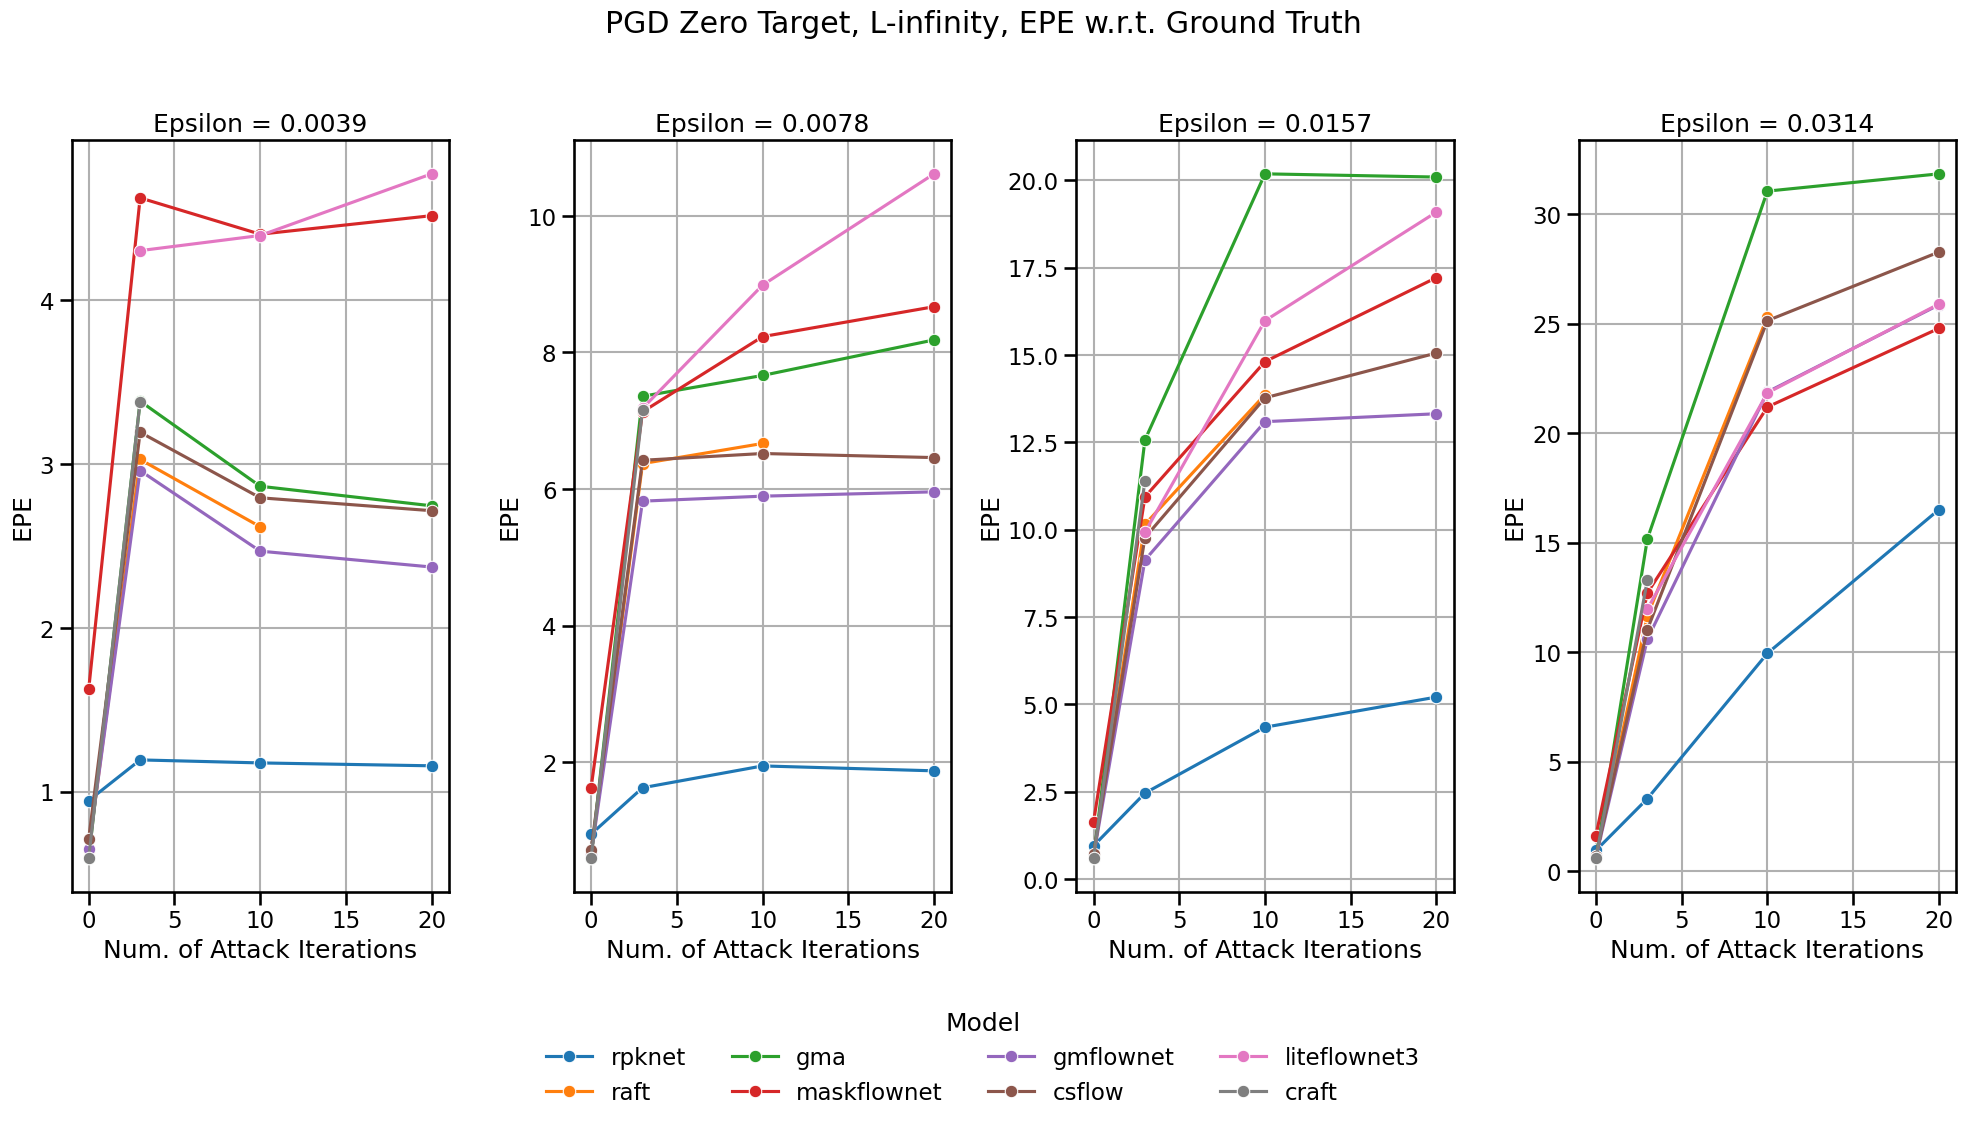

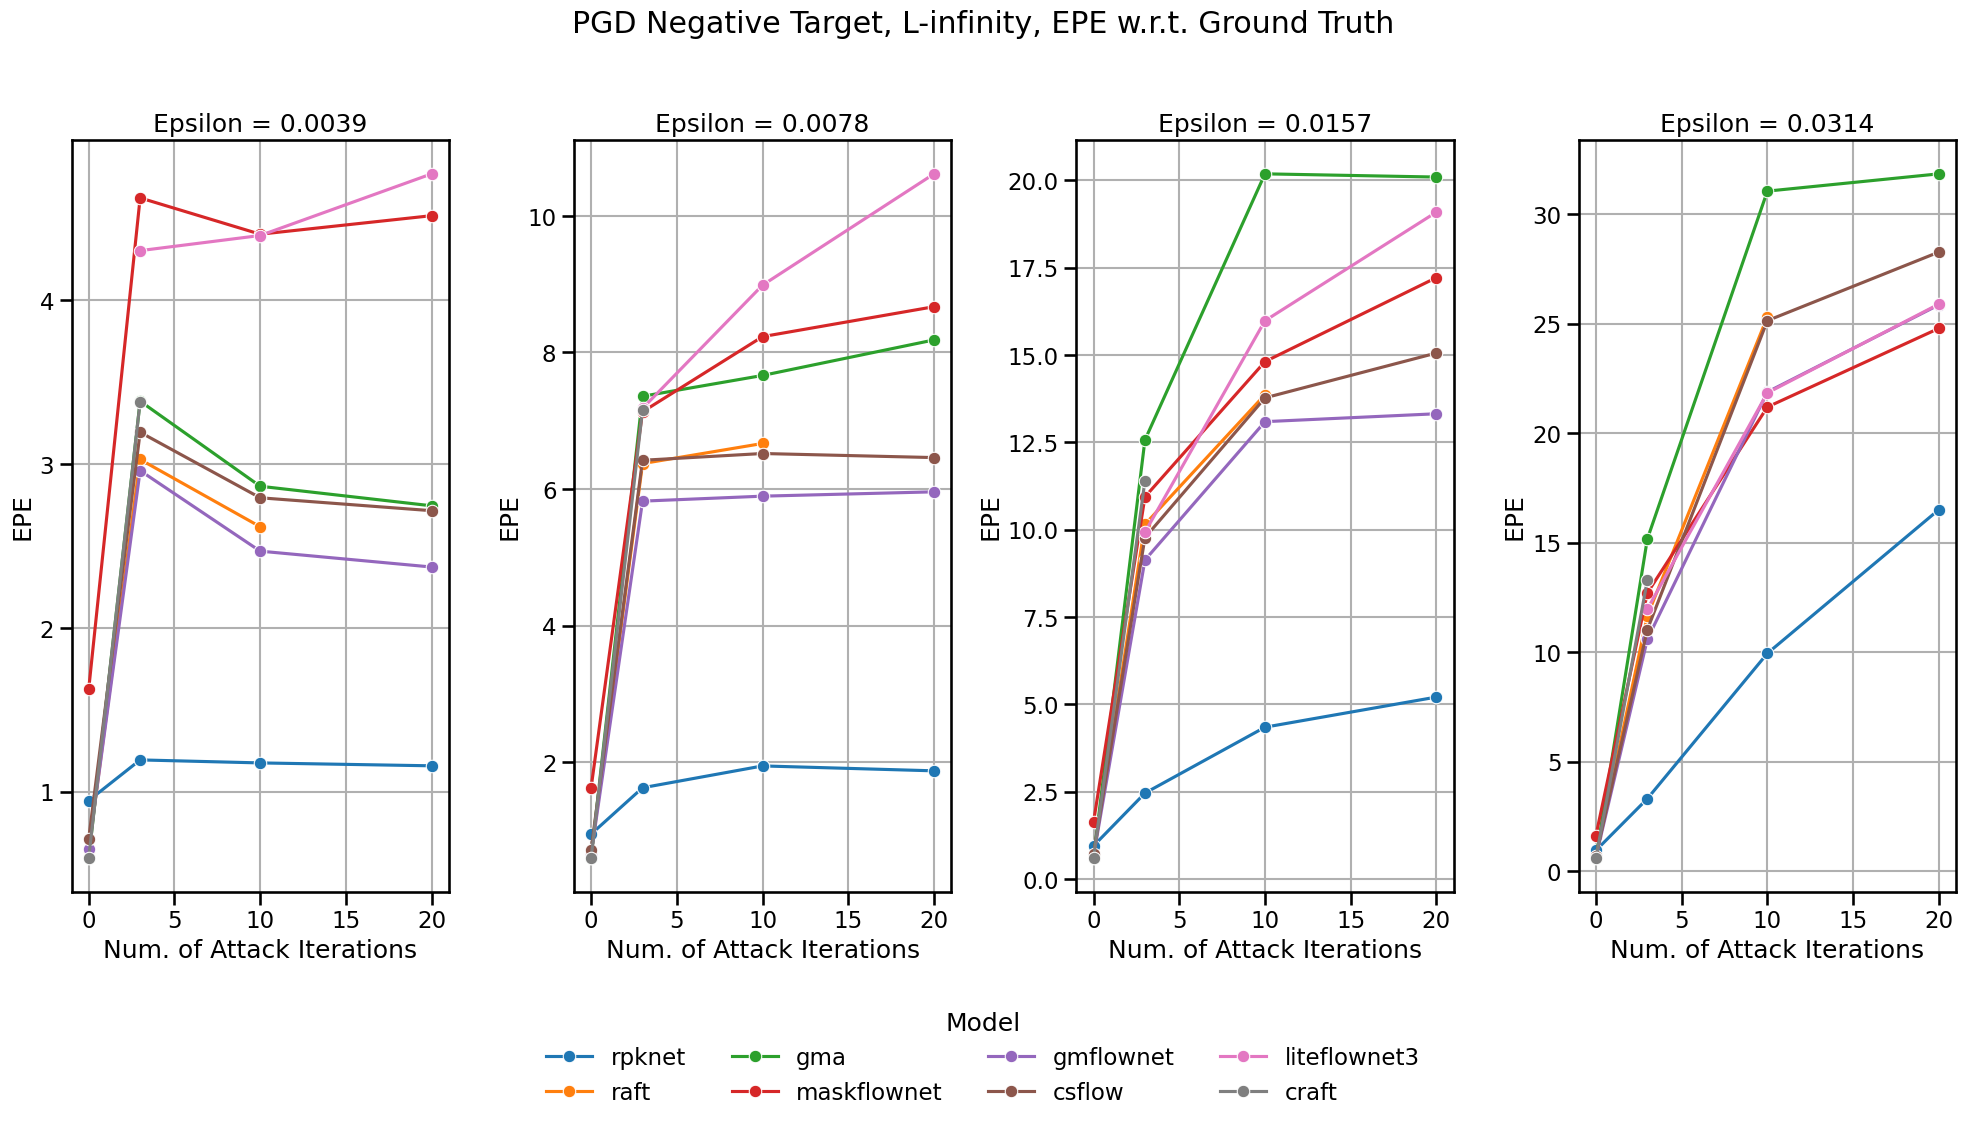

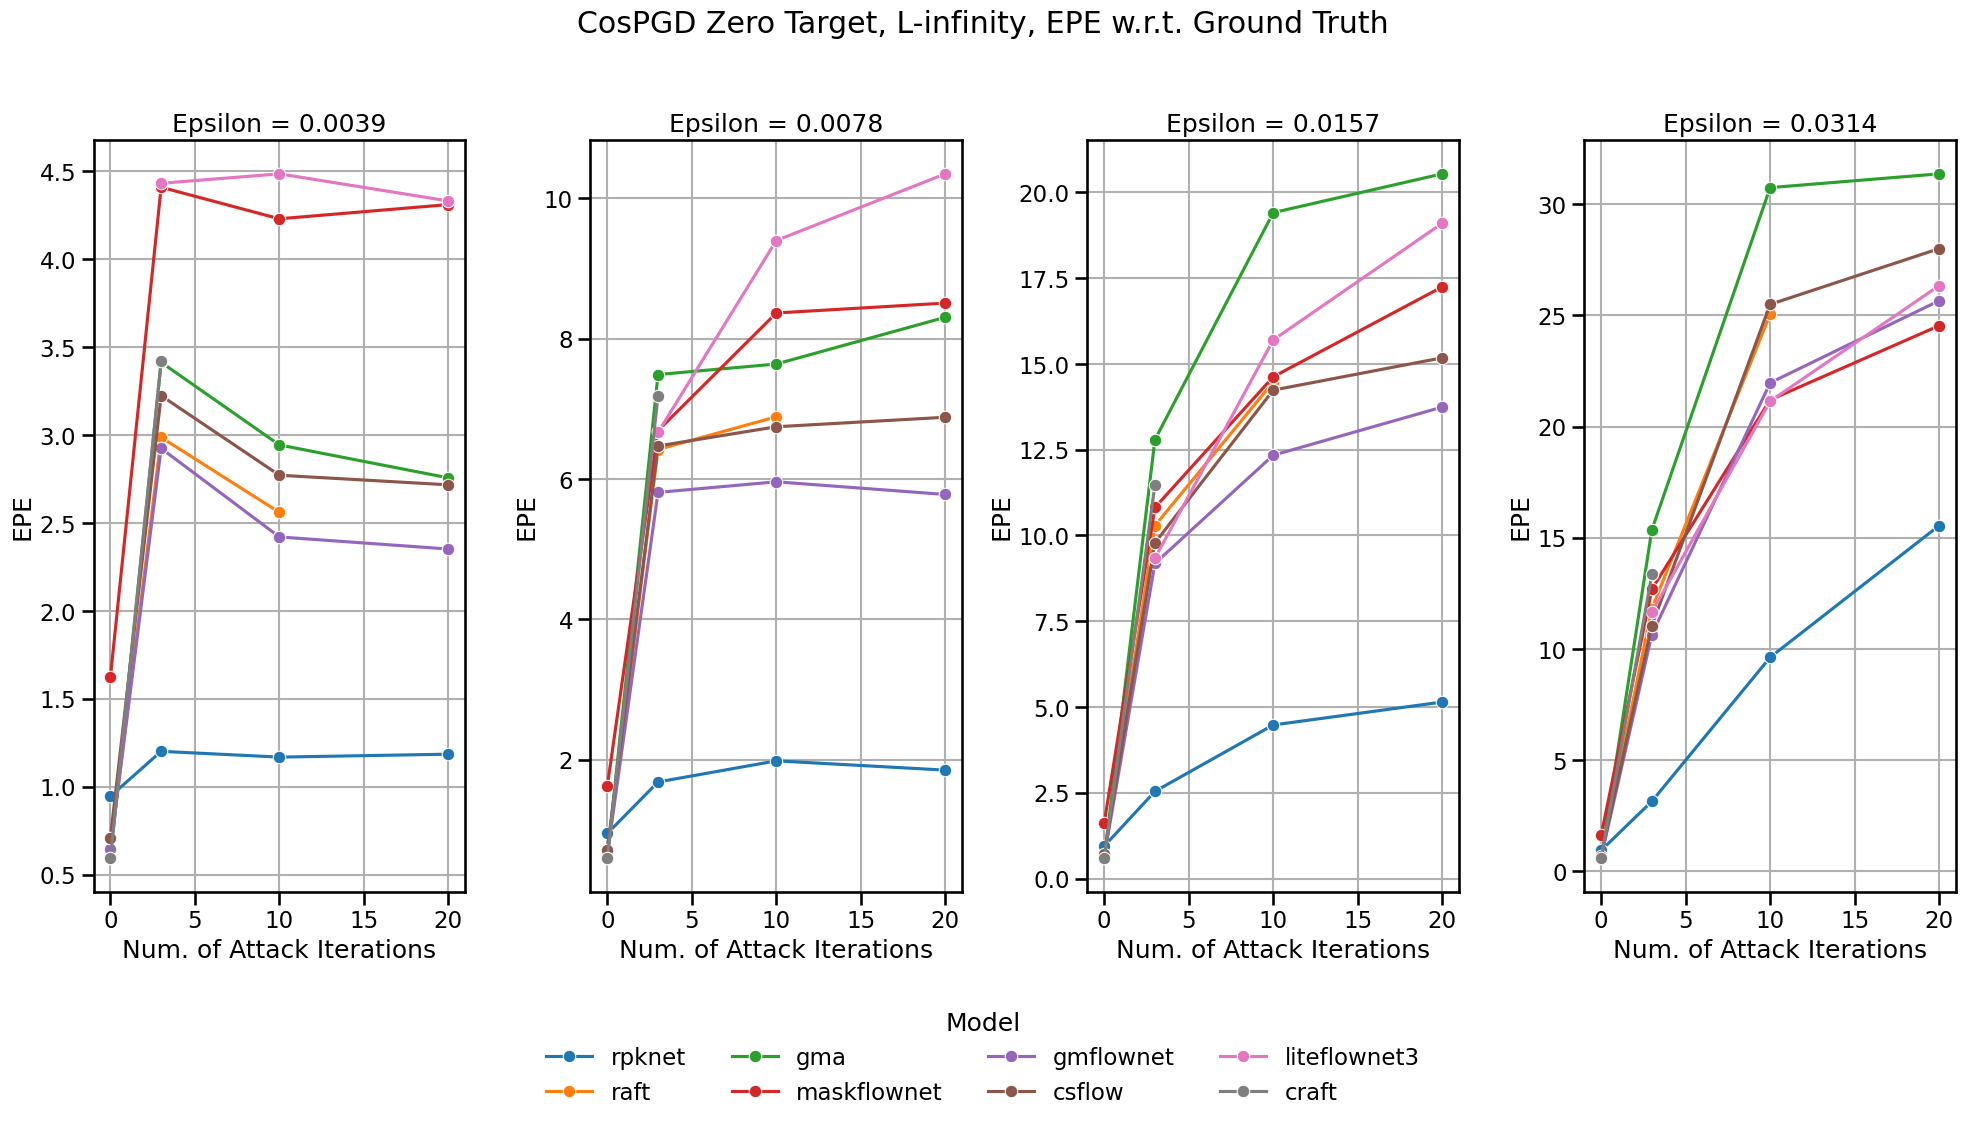

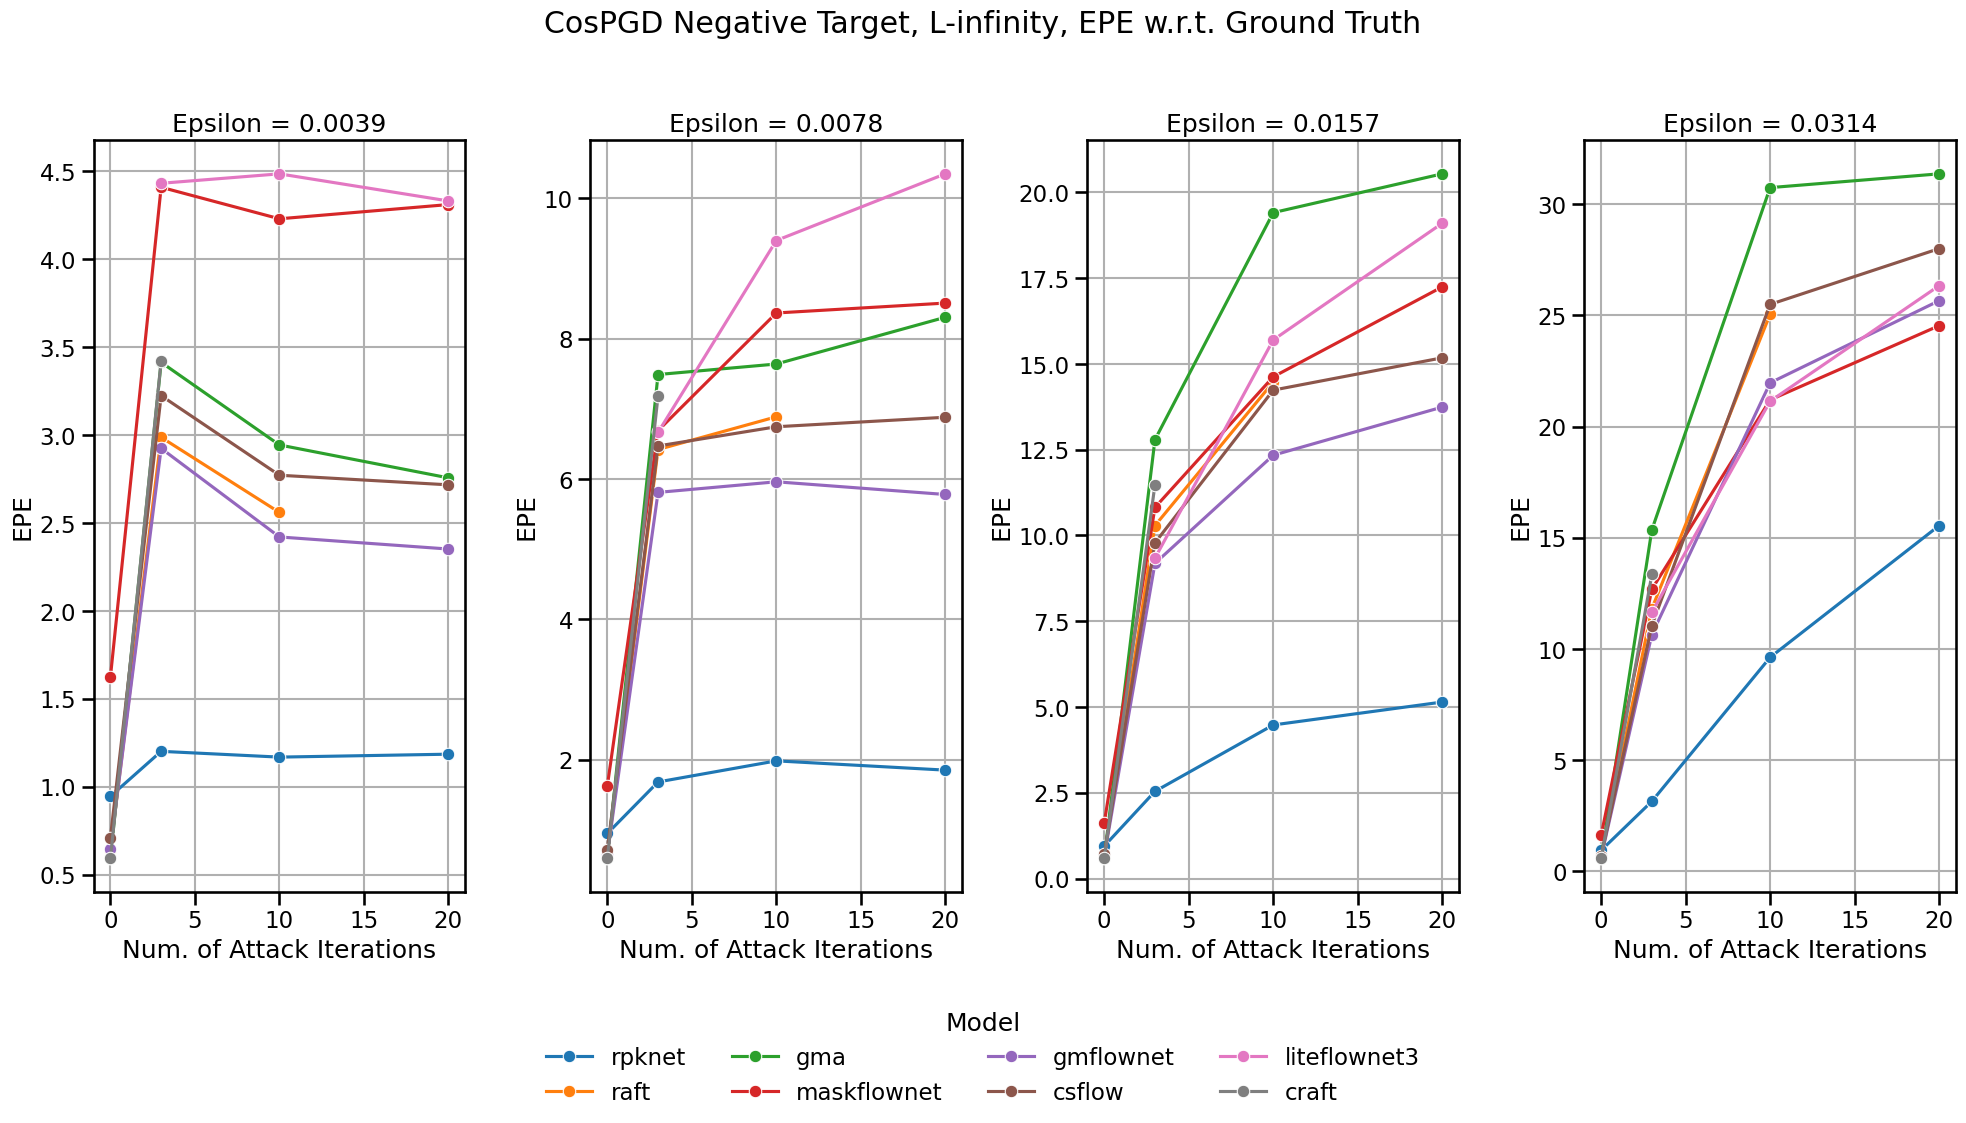

In [24]:
def plot_bim(data, title, filename, epsilon_values):
    num_epsilon = len(epsilon_values)
    fig, axes = plt.subplots(1, num_epsilon, figsize=(5 * num_epsilon, 10))
    fig.suptitle(title)

    if num_epsilon == 1:
        axes = [axes]

    for ax, epsilon in zip(axes, epsilon_values):
        # Create the plot for each epsilon
        sns.lineplot(data=data.query(f"epsilon == {epsilon} or epsilon == 0"), x='iterations', y='epe_ground_truth', hue='model', marker='o', ax=ax)
        ax.set_title(f'Epsilon = {epsilon}')
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE')
        ax.grid(True)

    # Remove individual legends by setting legend to False in sns.lineplot
    for ax in axes:
        ax.legend().remove()

    # Adjust the legend position and add it to the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title and legend
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

### BIM ###

# Plot for targeted attack with target zero
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_target_zero_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_target_zero_inf, 'BIM Zero Target, L-infinity, EPE w.r.t. Ground Truth', 'graphs/BIM Zero Target Inf-Norm to gt.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with negative target
query = "attack == 'bim' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_target_negative_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_target_zero_inf, 'BIM Negative Target, L-infinity, EPE w.r.t. Ground Truth', 'graphs/BIM Negative Target Inf-Norm to gt.png', [0.0039, 0.0078, 0.0157, 0.0314])


### PGD ###

# Plot for targeted attack with target zero
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_target_zero_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_target_zero_inf, 'PGD Zero Target, L-infinity, EPE w.r.t. Ground Truth', 'graphs/PGD Zero Target Inf-Norm to gt.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with negative target
query = "attack == 'pgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_target_negative_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_target_zero_inf, 'PGD Negative Target, L-infinity, EPE w.r.t. Ground Truth', 'graphs/PGD Negative Target Inf-Norm to gt.png', [0.0039, 0.0078, 0.0157, 0.0314])


### CosPGD ###

# Plot for targeted attack with target zero
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_target_zero_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_target_zero_inf, 'CosPGD Zero Target, L-infinity, EPE w.r.t. Ground Truth', 'graphs/CosPGD Zero Target Inf-Norm to gt.png', [0.0039, 0.0078, 0.0157, 0.0314])

# Plot for targeted attack with negative target
query = "attack == 'cospgd' and norm == 'inf' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'"
model_list = df.query(query)["model"].unique()
data_target_negative_inf = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_bim(data_target_zero_inf, 'CosPGD Negative Target, L-infinity, EPE w.r.t. Ground Truth', 'graphs/CosPGD Negative Target Inf-Norm to gt.png', [0.0039, 0.0078, 0.0157, 0.0314])

#### BIM/PGD/CosPGD ALL Models TWO


/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


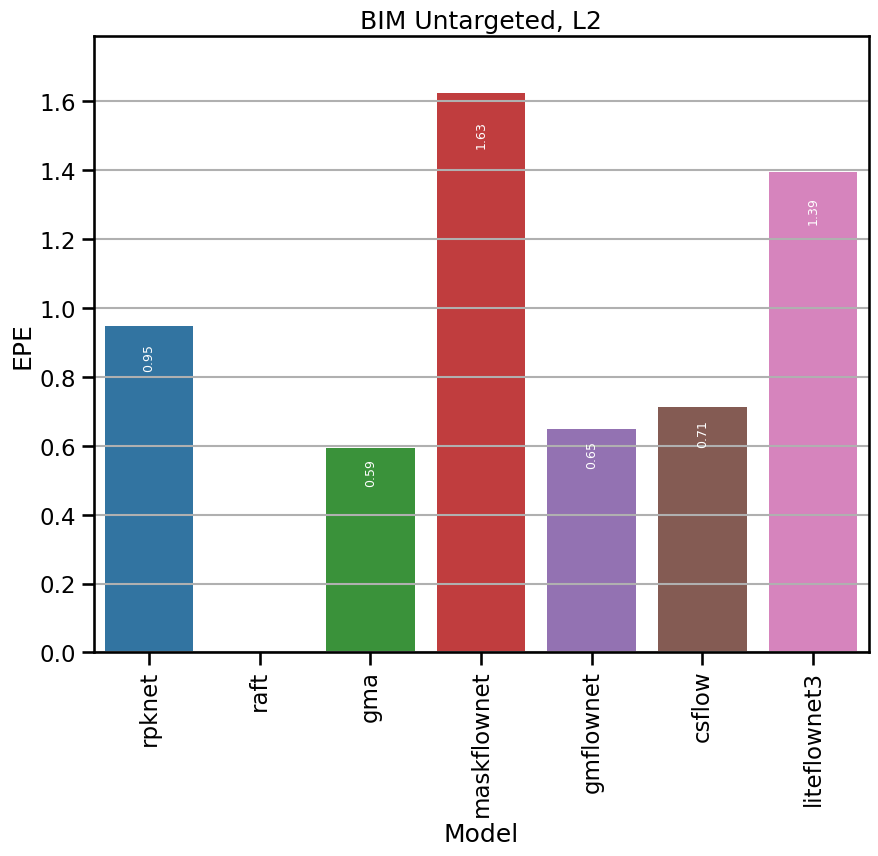

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


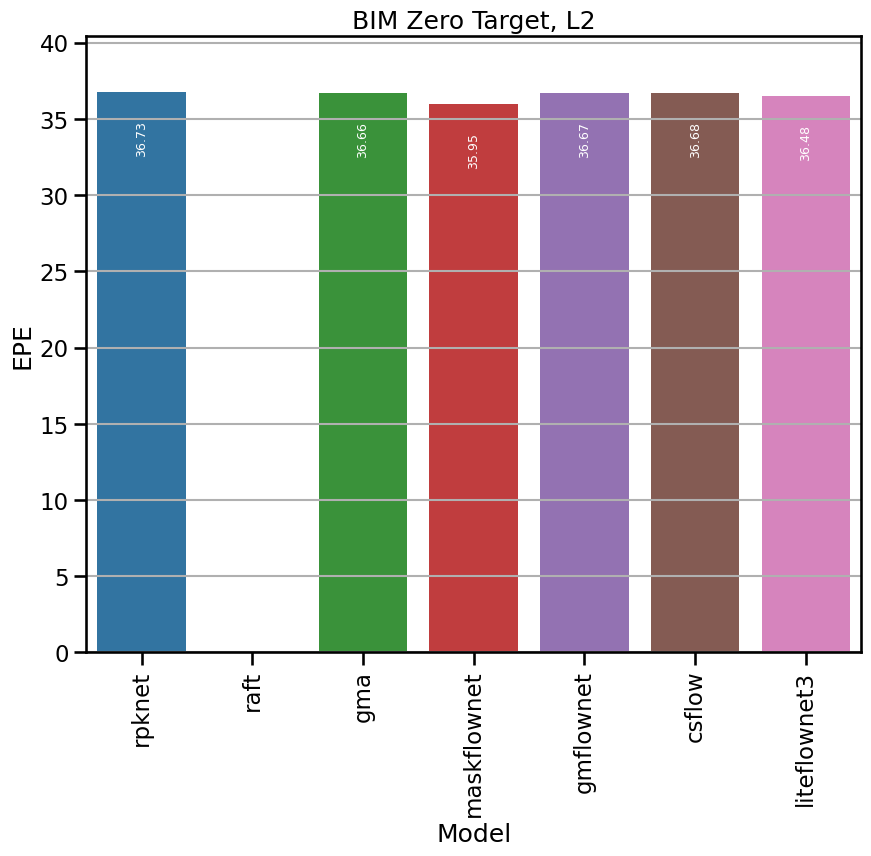

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


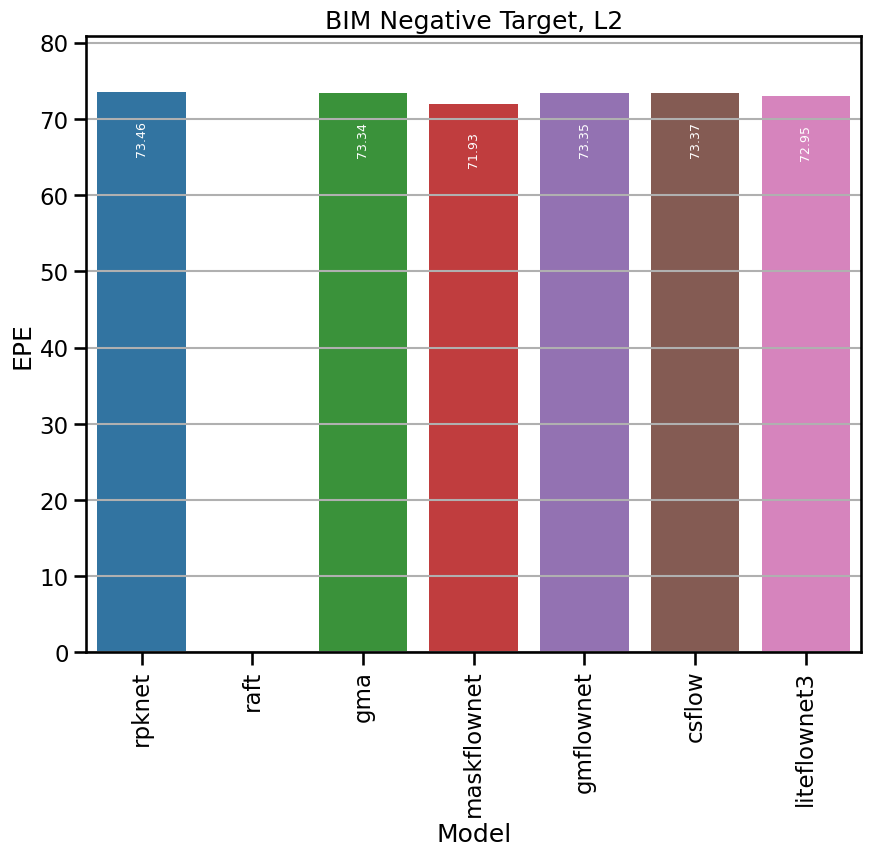

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


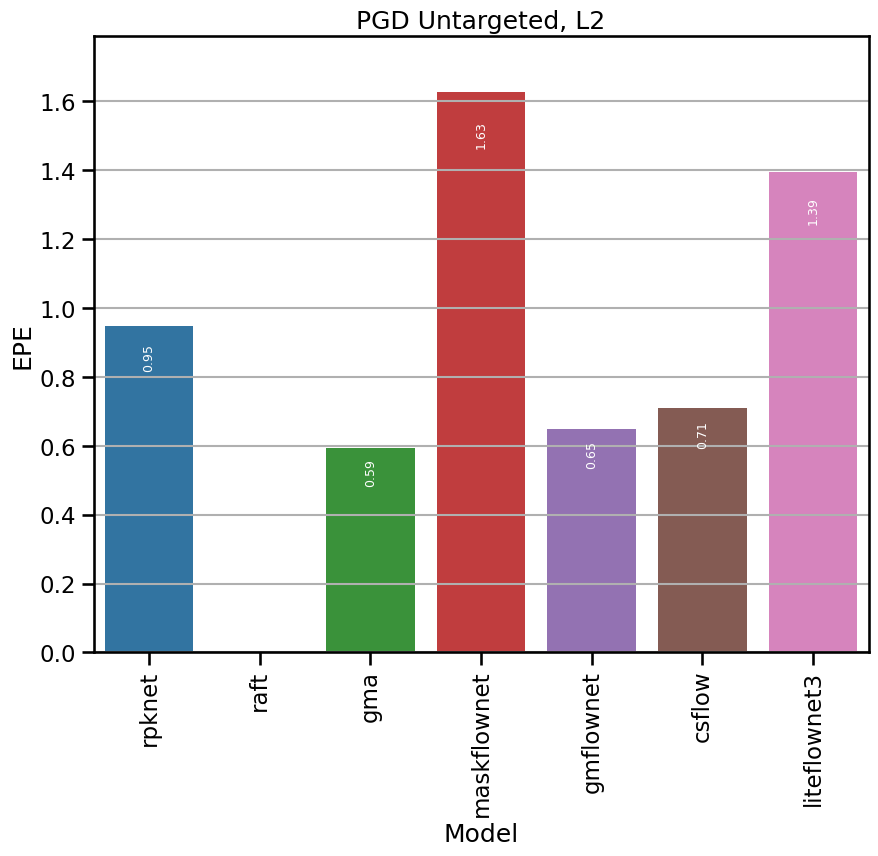

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


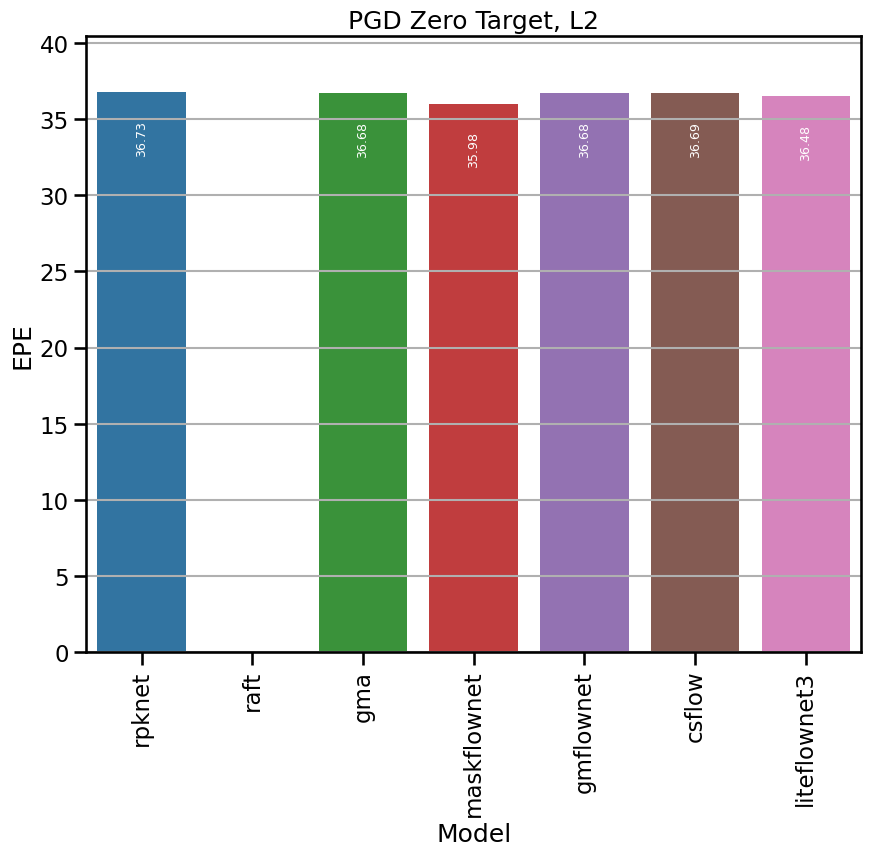

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


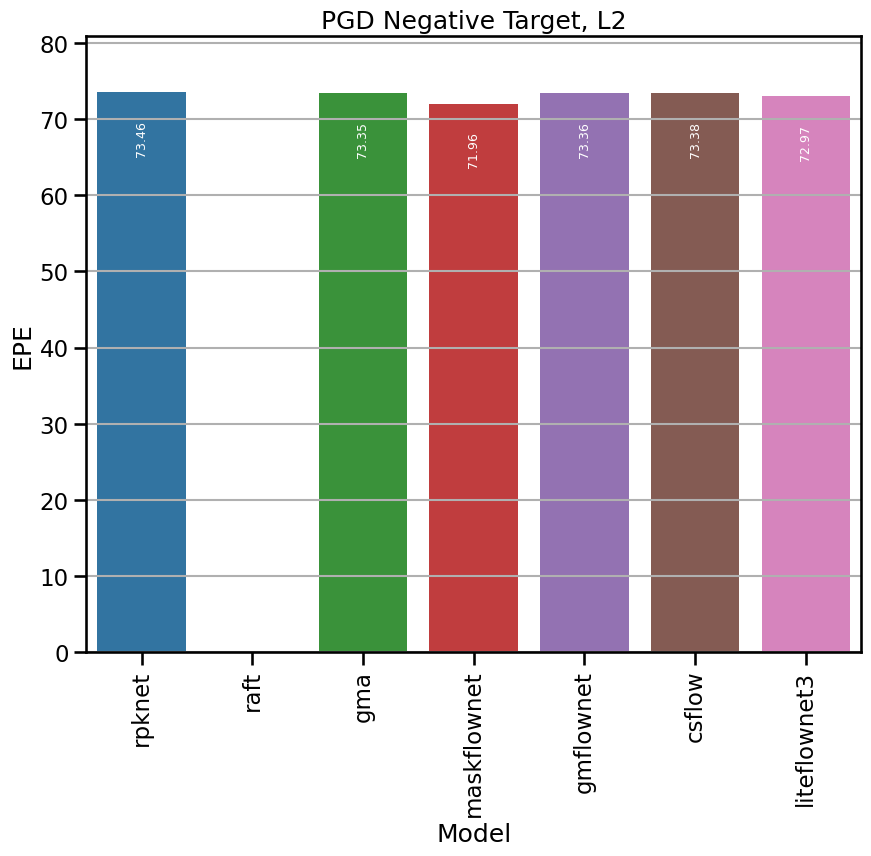

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


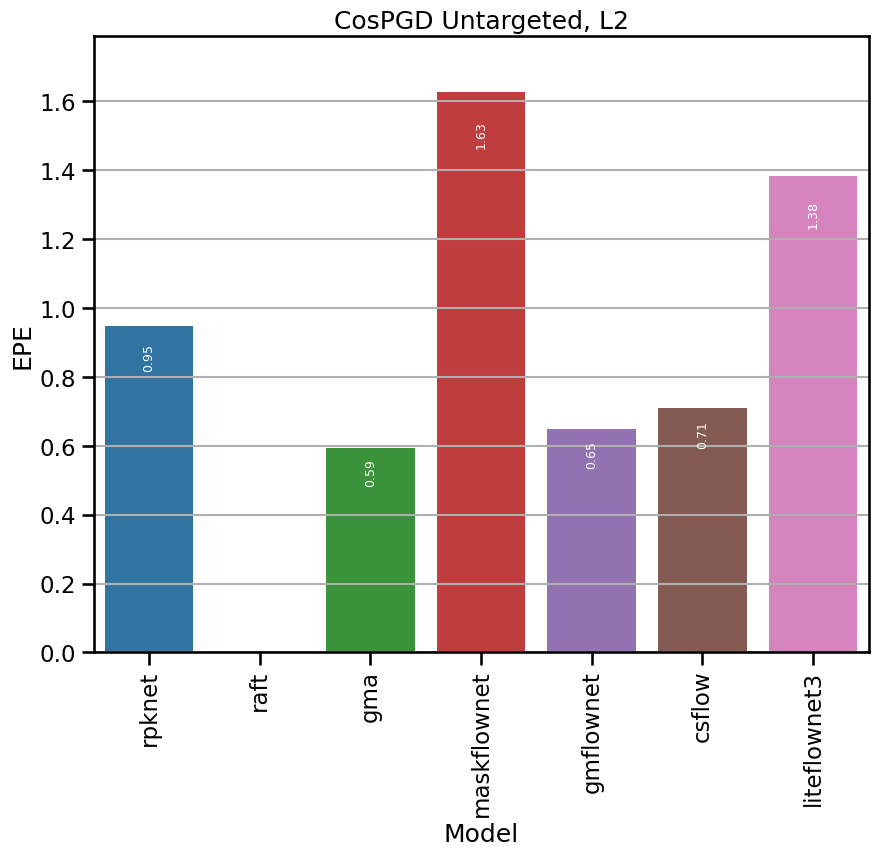

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


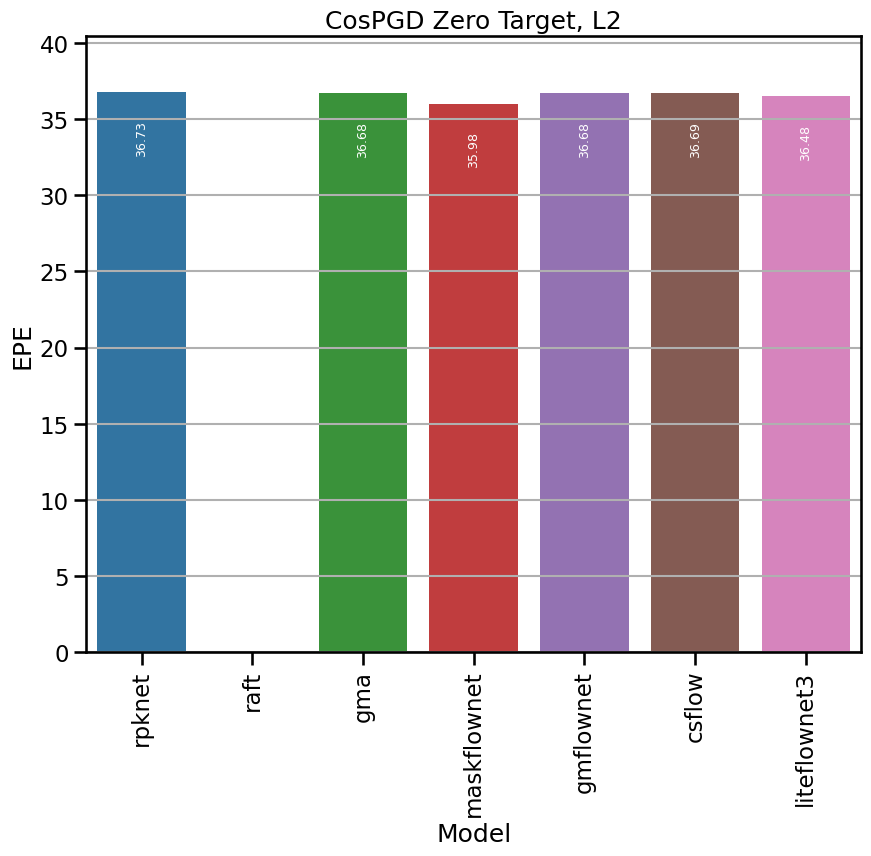

/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/1574823770.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


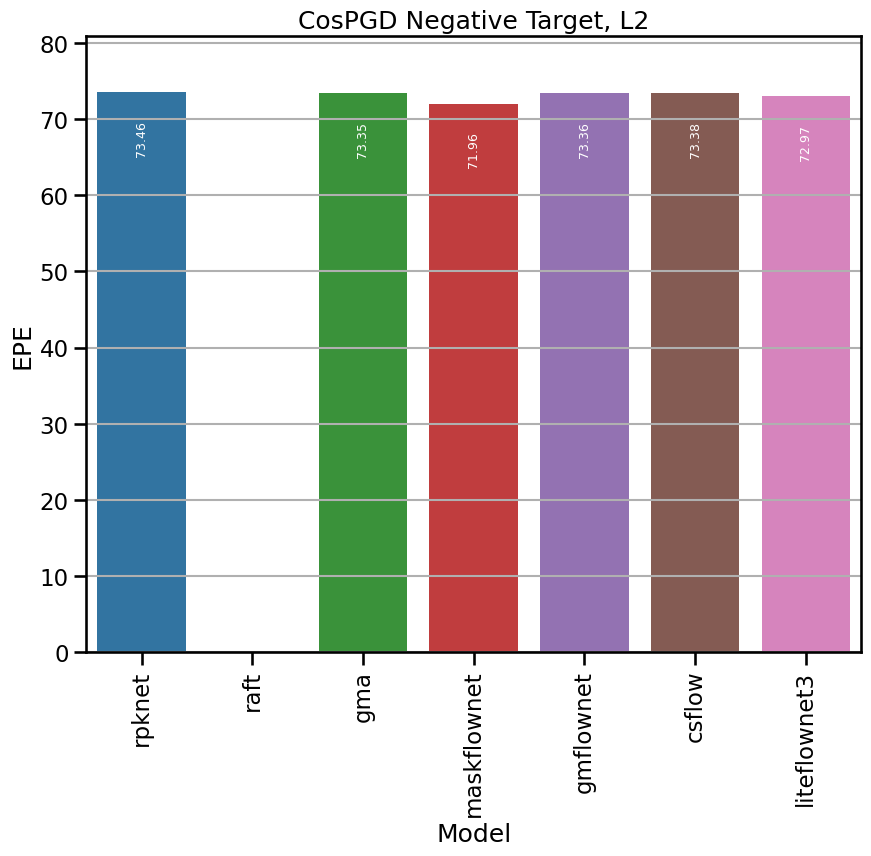

In [25]:
def plot_data(data, title, filename, specific_models=False):
    if data.empty:
        print(f"No data available for {title}. Skipping plot.")
        return

    # Create the plot
    plt.figure(figsize=(10, 8))
    bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')

    # Customize the plot
    plt.xlabel('Model')
    plt.ylabel('EPE')
    plt.title(title)
    plt.grid(True, axis='y')

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation=90)

    # Annotate each bar with the y value within the bar at the top
    for bar in bar_plot.patches:
        bar_height = bar.get_height()
        if specific_models:
            bar_plot.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height - bar_height * 0.10,  # Adjusted for better alignment
                f'{bar_height:.2f}',
                ha='center',
                va='top',
                rotation=0,  # Horizontal text
                color='white',
                fontsize=12  # Larger font size
            )
        else:
            bar_plot.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height - bar_height * 0.05,
                f'{bar_height:.2f}',
                ha='center',
                va='top',
                rotation=90,  # Vertical text
                color='white',
                fontsize=9
            )

    # Adjust y-axis limit to make sure the annotations fit within the frame
    max_epe = data['epe'].max()
    plt.ylim(0, max_epe * 1.1)

    # Show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

### BIM ###

# Plot for untargeted attack
data_untargeted_two = df.query("attack == 'bim' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_untargeted_two, 'BIM Untargeted, L2', 'graphs/BIM Untargeted Two Norm_bar.png')

# Plot for targeted attack with target zero
data_target_zero_two = df.query("attack == 'bim' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_zero_two, 'BIM Zero Target, L2', 'graphs/BIM Zero Target Two-Norm_bar.png')

# Plot for targeted attack with negative target
data_target_negative_two = df.query("attack == 'bim' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_negative_two, 'BIM Negative Target, L2', 'graphs/BIM Negative Target Two-Norm_bar.png')


### PGD ###

# Plot for untargeted attack
data_untargeted_two = df.query("attack == 'pgd' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_untargeted_two, 'PGD Untargeted, L2', 'graphs/PGD Untargeted Two Norm_bar.png')

# Plot for targeted attack with target zero
data_target_zero_two = df.query("attack == 'pgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_zero_two, 'PGD Zero Target, L2', 'graphs/PGD Zero Target Two-Norm_bar.png')

# Plot for targeted attack with negative target
data_target_negative_two = df.query("attack == 'pgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_negative_two, 'PGD Negative Target, L2', 'graphs/PGD Negative Target Two-Norm_bar.png')


### CosPGD ###

# Plot for untargeted attack
data_untargeted_two = df.query("attack == 'cospgd' and norm == 'two' and targeted == False and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_untargeted_two, 'CosPGD Untargeted, L2', 'graphs/CosPGD Untargeted Two Norm_bar.png')

# Plot for targeted attack with target zero
data_target_zero_two = df.query("attack == 'cospgd' and norm == 'two' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_zero_two, 'CosPGD Zero Target, L2', 'graphs/CosPGD Zero Target Two-Norm_bar.png')

# Plot for targeted attack with negative target
data_target_negative_two = df.query("attack == 'cospgd' and norm == 'two' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti'")
plot_data(data_target_negative_two, 'CosPGD Negative Target, L2', 'graphs/CosPGD Negative Target Two-Norm_bar.png')

### PCFA, w.r.t. Target Flow

/scratch/ipykernel_800325/2440358499.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2440358499.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


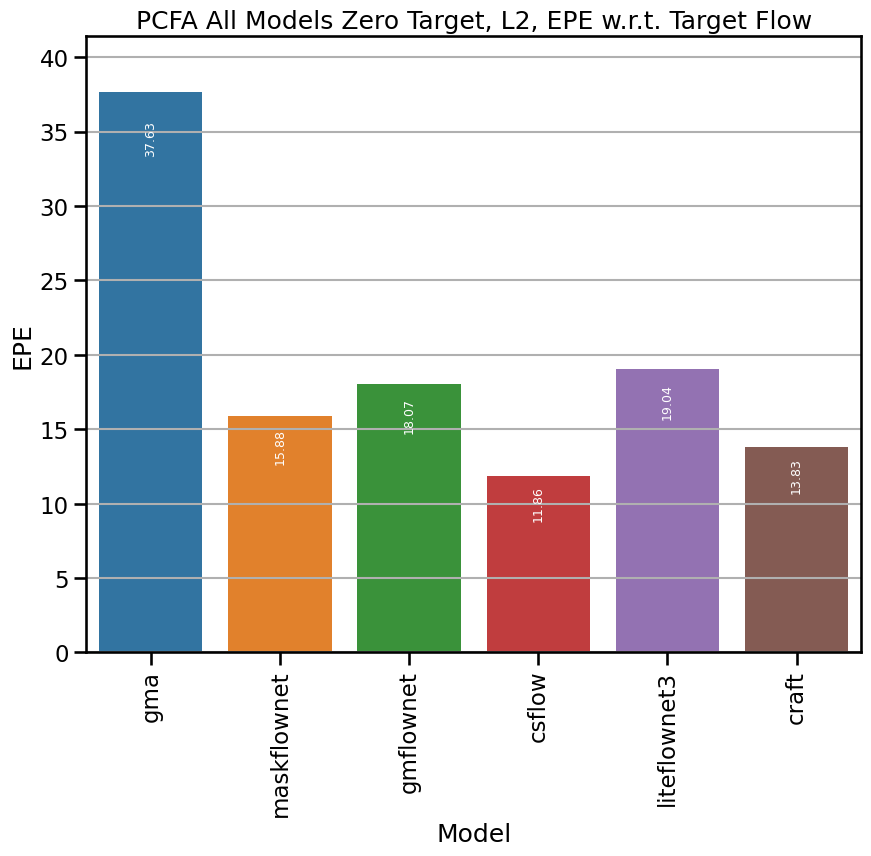

/scratch/ipykernel_800325/2440358499.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')
/scratch/ipykernel_800325/2440358499.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')


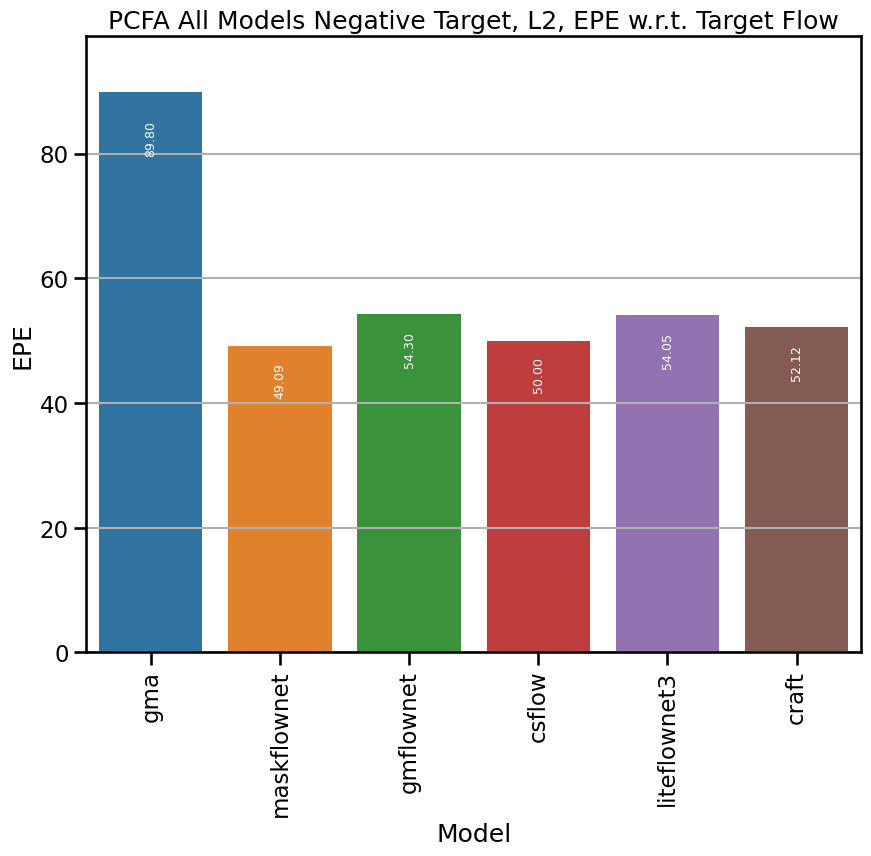

In [26]:
def plot_data(data, title, filename, specific_models=False):
    if data.empty:
        print(f"No data available for {title}. Skipping plot.")
        return

    # Create the plot
    plt.figure(figsize=(10, 8))
    bar_plot = sns.barplot(data=data, x='model', y='epe', ci=None, palette='tab10')

    # Customize the plot
    plt.xlabel('Model')
    plt.ylabel('EPE')
    plt.title(title)
    plt.grid(True, axis='y')

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation=90)

    # Annotate each bar with the y value within the bar at the top
    for bar in bar_plot.patches:
        bar_height = bar.get_height()
        if specific_models:
            bar_plot.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height - bar_height * 0.10,  # Adjusted for better alignment
                f'{bar_height:.2f}',
                ha='center',
                va='top',
                rotation=0,  # Horizontal text
                color='white',
                fontsize=12  # Larger font size
            )
        else:
            bar_plot.text(
                bar.get_x() + bar.get_width() / 2,
                bar_height - bar_height * 0.05,
                f'{bar_height:.2f}',
                ha='center',
                va='top',
                rotation=90,  # Vertical text
                color='white',
                fontsize=9
            )

    # Adjust y-axis limit to make sure the annotations fit within the frame
    max_epe = data['epe'].max()
    plt.ylim(0, max_epe * 1.1)

    # Show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot for targeted attack with target zero
data_target_zero = df.query("attack == 'pcfa' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti' and iterations == 20")
plot_data(data_target_zero, "PCFA All Models Zero Target, L2, EPE w.r.t. Target Flow", 'graphs/PCFA All Models Zero Target 2-Norm.png')

# Plot for targeted attack with negative target
data_target_negative = df.query("attack == 'pcfa' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti' and iterations == 20")
plot_data(data_target_negative, "PCFA All Models Negative Target, L2, EPE w.r.t. Target Flow", 'graphs/PCFA All Models Negative Target 2-Norm.png')


#### PCFA w.r.t. Ground Truth

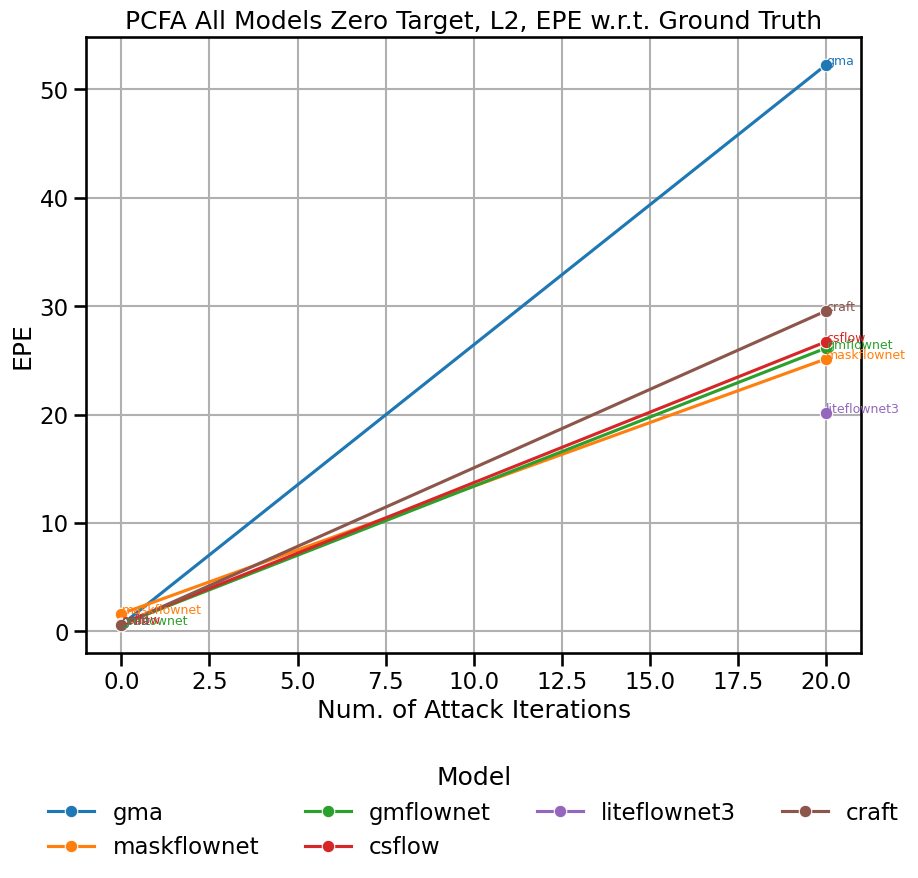

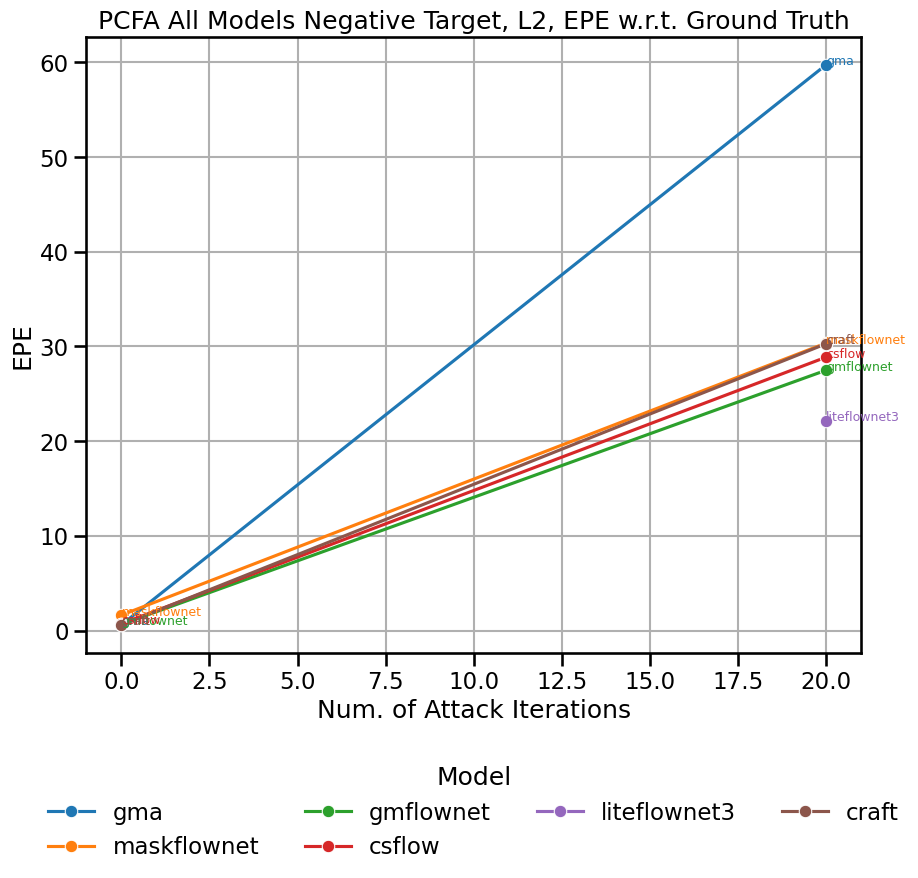

In [27]:
def plot_line(data, title, filename):
    # Create the plot
    plt.figure(figsize=(10, 8))
    line_plot = sns.lineplot(data=data, x='iterations', y='epe_ground_truth', hue='model', marker='o')

     # Customize the plot
    plt.xlabel('Num. of Attack Iterations')
    plt.ylabel('EPE')
    plt.grid(True)
    plt.title(title)

    # Add annotations
    # Get colors from the legend
    handles, labels = line_plot.get_legend_handles_labels()
    legend_colors = dict(zip(labels, [handle.get_color() for handle in handles]))

    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        for i in range(model_data.shape[0]):
            plt.text(model_data['iterations'].iloc[i], model_data['epe_ground_truth'].iloc[i], model, fontsize=9, color=legend_colors[model])

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)

    # Show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# Plot for targeted attack with target zero
query = "attack == 'pcfa' and targeted == True and target == 'zero' and dataset == 'kitti-2015' and checkpoint == 'kitti' and iterations == 20"
model_list = df.query(query)["model"].unique()
data_target_zero = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_line(data_target_zero, "PCFA All Models Zero Target, L2, EPE w.r.t. Ground Truth", 'graphs/PCFA All Models Zero Target 2-Norm to gt.png')

# Plot for targeted attack with negative target
query = "attack == 'pcfa' and targeted == True and target == 'negative' and dataset == 'kitti-2015' and checkpoint == 'kitti' and iterations == 20"
model_list = df.query(query)["model"].unique()
data_target_negative = df.query(query + " or (attack == 'none' and checkpoint == 'kitti' and model in @model_list)")
plot_line(data_target_negative, "PCFA All Models Negative Target, L2, EPE w.r.t. Ground Truth", 'graphs/PCFA All Models Negative Target 2-Norm to gt.png')
